# Evaluate AlphaFold predicted structures using cross-links

## Set up for calculating cross-link distances from PDB structures

In [38]:
import matplotlib.pyplot as plt
from biopandas.pdb import PandasPdb
from os.path import exists
import numpy as np
import pandas as pd
import seaborn as sns
import json
from scipy.stats import gaussian_kde as kde
from collections import Counter
from scipy import ndimage as ndi
from skimage.morphology import square
from skimage.segmentation import watershed
from skimage.filters import rank
from skimage.util import img_as_ubyte
import matplotlib.image as mpimg

PATH_XLS_INTRA_NONRED = 'XLs_intra_nonred.csv'
PATH_WATERSHED_LABELS = 'watershed_labels.json'

UNRELAXED_PDB_SUFFIX = '-unrelaxed_model_1.pdb'
RELAXED_PDB_SUFFIX = '-relaxed_model_1.pdb'
UNRELAXED_PTM_PDB_SUFFIX = '-unrelaxed_model_1_ptm.pdb'
RELAXED_PTM_PDB_SUFFIX = '-relaxed_model_1_ptm.pdb'
PAE_PKL_SUFFIX = '-pae_model_1_ptm.pkl'

XL_THRESHOLD = 30

pdbs = {}
paes = {}

all_proteins = ['IFT172', 'IDP2\xa0', 'Q23TY1', 'Q234E6', 'I7MHP2', 'CDC27', 'SARS', 'Q24GN6', 'DLD', 'EEF2', 'Q24FH6',
                'GNPDA1/2', 'Q23A15', 'PGK1', 'SPEF2', 'EIF4A', 'Q23DV1', 'Q22T19', 'I7LWT9', 'I7ML23',
                'ILS1', 'I7LUZ1', 'DARS', 'Q24CJ0', 'CASC1', 'BBC52', 'CAPN-1', 'I7M2E8', 'I7M2A9', 'EPC1', 'KARS',
                'I7LXF9', 'I7LX35', 'GRS1', 'I7MCM4', 'EARS', 'YARS', 'I7MJ59', 'I7MKN3', 'TFA', 'I7M3K6', 'LRS1',
                'PRKAR1A', 'RANGAD1', 'BBC118', 'HSPA4', 'IGR3', 'MRNC57', 'VMA1', 'I7MHD4', 'SPAG17', 'DPY30-1',
                'MRNO36', 'RPS0', 'I7MFS4', 'Q22MP6', 'jacalin-1', 'Q22AS9', 'MPK3', 'DIC3', 'Q24C62', 'DIC2', 'I7M6H8',
                'PGM1', 'UBXN2A/B', 'FTT18', 'CCDC81-1', 'PGI1', 'EMAP5/6-2', 'VMA5', 'EMAP5/6-1', 'CCDC96',
                'TTC18', 'I7LZI8', 'NPEPL1/LAP3', 'I7MEJ5', 'EF1A', 'PRKG1', 'BBC73', 'ACBD7', 'RACK1',
                'I7M328', 'TRAF3IP1', 'Q23F83', 'I7M350', 'AK1-1', 'I7MDK2', 'I7M0R3', 'HSP90AA1', 'FBPA', 'ACO1-2',
                'ME1/2/3', 'I7LW80', 'TRS1', 'I7LZE3', 'Q23FF1', 'I7M4K0', 'I7LTB9', 'DRH29', 'PRS1']

def sanitize_protein(protein_id):
    """Replace / in protein ID with _ for compatibility with file system, and remove illegal characters."""
    return protein_id.replace("/", "_").replace("\xa0", "")


def calculate_dist(pdb, xl):
    """Calculate the distance between residues in the PDB based on the crosslink"""
    # Find the C atom for each residue
    res_1 = pdb.loc[pdb['residue_number'] == xl.Res1]
    res_2 = pdb.loc[pdb['residue_number'] == xl.Res2]

    res_1_coords = res_1[['x_coord', 'y_coord', 'z_coord']].to_numpy()
    res_2_coords = res_2[['x_coord', 'y_coord', 'z_coord']].to_numpy()

    return np.linalg.norm(res_1_coords - res_2_coords)


def read_pdb_ca(pdb_filepath):
    """Read atom data for the alpha carbon from a PDB at the given filepath"""
    ppdb = PandasPdb().read_pdb(pdb_filepath)  # reads pdb into pandas df
    pdbatom = ppdb.df['ATOM']  # extracts only the atom data type from pdb
    return pdbatom[(pdbatom['atom_name'] == 'CA')]  # selects the only the CA atoms


def read_protein_pdb(protein, pdb_suffix):
    """Cached read of a PDB file for the given protein with the provided file suffix"""
    if pdb_suffix not in pdbs:
        pdbs[pdb_suffix] = {}
    elif protein in pdbs[pdb_suffix]:
        return pdbs[pdb_suffix][protein]
    pdbs_with_suffix = pdbs[pdb_suffix]

    pdb_filepath = 'models/' + sanitize_protein(protein) + pdb_suffix
    if not exists(pdb_filepath):
        # print(protein + ' PDB file not found. Skipping...')
        return None
    pdb_ca = read_pdb_ca(pdb_filepath)

    pdbs_with_suffix[protein] = pdb_ca
    return pdb_ca


def read_protein_pae(protein):
    """Cached read of PAE results for the given protein"""
    if protein in paes:
        return paes[protein]

    results = pd.read_pickle('pae/' + sanitize_protein(protein) + PAE_PKL_SUFFIX)
    pae = results['predicted_aligned_error']
    paes[protein] = pae
    return pae


def fill_xls_from_pdb(protein_name, threshold, pdb, xls):
    """Calculate distance between residues for every cross-link for a protein in xls based on alpha carbon positions in pdb. Returns cross-links which are below the threshold distance."""
    xls['af_distance'] = xls.apply(
        lambda x: x.af_distance if x.Protein1 != protein_name else calculate_dist(pdb, x), axis=1)
    return xls[(xls['af_distance'] < threshold) & (xls['Protein1'] == protein_name)]


## Read intra-protein cross-link data

In [39]:
if exists(PATH_XLS_INTRA_NONRED):
    # Read intra-protein cross-links from file if it exists
    XLs_intra_nonred = pd.read_csv(PATH_XLS_INTRA_NONRED)
else:
    # Read in XL csv file to pandas DF
    XLs = pd.read_csv("Union_XL1_XL2_PurifiedSECa-g_IEXcilia2inject2.3-newpeptidepos.csv", encoding='unicode_escape')

    # Save all intramolecular crosslinks to a new DF
    XLs_intra = XLs.loc[XLs['Protein1'] == XLs['Protein2']]

    # Calculate the XL position in the protein primary sequence
    XLs_intra.loc[:, 'Res1'] = XLs_intra['PepPos1'] + XLs_intra['LinkPos1'] - 1
    XLs_intra.loc[:, 'Res2'] = XLs_intra['PepPos2'] + XLs_intra['LinkPos2'] - 1

    # Removes all XL redundancies
    XLs_intra.loc[:, 'newRes1'] = XLs_intra[["Res1", "Res2"]].max(axis=1)
    XLs_intra.loc[:, 'newRes2'] = XLs_intra[["Res1", "Res2"]].min(axis=1)
    XLs_intra_nonred = XLs_intra.drop_duplicates(subset=['Protein1', 'Protein2', 'newRes1', 'newRes2'], keep="last")

    # Remove all XLs with the same res1 as res2
    print(XLs_intra_nonred[XLs_intra_nonred['newRes1'] == XLs_intra_nonred['newRes2']])
    XLs_intra_nonred.drop(XLs_intra_nonred[XLs_intra_nonred['newRes1'] == XLs_intra_nonred['newRes2']].index,
                          inplace=True)

    # Remove proteins not in top 100 most cross-linked
    XLs_intra_nonred = XLs_intra_nonred[XLs_intra_nonred['Protein1'].isin(all_proteins)]

    # Save to file
    XLs_intra_nonred.to_csv(PATH_XLS_INTRA_NONRED)

## Count cross-links satisfied in AlphaFold predicted structures

In [40]:
def get_af_xl_counts(protein_xl_counts, threshold, pdb_suffix):
    """Retrieve the number of cross-links for this protein where the residue distance in the PDB with the given suffix is below the threshold."""
    protein = protein_xl_counts['Protein1']
    pdb_ca = read_protein_pdb(protein, pdb_suffix)
    if pdb_ca is None:
        return None
    return fill_xls_from_pdb(protein, threshold, pdb_ca, XLs_intra_nonred).count()['Id']

In [41]:
# Extract XL counts for each protein
intra_XL_counts = XLs_intra_nonred['Protein1'].value_counts().reset_index().rename(
    columns={'index': 'Protein1', 'Protein1': 'XL_count'})

# Calculate cross-link distances in AlphaFold structure and count those within the cross-link threshold for each protein
XLs_intra_nonred.loc[:, 'af_distance'] = None
intra_XL_counts['af_unrelaxed_XL_count'] = intra_XL_counts.apply(
    lambda x: get_af_xl_counts(x, XL_THRESHOLD, UNRELAXED_PDB_SUFFIX), axis=1)
intra_XL_counts[intra_XL_counts['af_unrelaxed_XL_count'].notnull()]

Protein1  XL_count  af_unrelaxed_XL_count
0       PRKG1        38                     35
1        EEF2        35                     25
2      MRNC57        34                     24
3   EMAP5/6-1        30                     30
4      I7MJ59        30                     17
..        ...       ...                    ...
95       PRS1         7                      7
96   CCDC81-1         7                      6
97     I7LZE3         7                      7
98     I7MEJ5         7                      7
99     I7LZI8         6                      5

[100 rows x 3 columns]

## Relationship between pLDDT and cross-link violation

In [42]:
def read_confidence(intra_xl_counts):
    """Read the overall PLDDT for the unrelaxed model 1 prediction from the ranking file."""
    protein = intra_xl_counts['Protein1']

    ranking_filepath = 'rankings/' + sanitize_protein(protein) + '-ranking_debug.json'
    if not exists(ranking_filepath):
        if not np.isnan(intra_xl_counts['af_unrelaxed_XL_count']):
            print('Rankings for', protein, 'not found.')
        return None

    with open(ranking_filepath) as ranking_file:
        ranking_debug = json.load(ranking_file)
        if 'model_1' in ranking_debug['plddts']:
            return ranking_debug['plddts']['model_1']
        else:
            print('Did not have model_1 plddt (was predicted using Alphafold 2.2):', protein)
            return ranking_debug['plddts']['model_1_pred_0']


intra_XL_counts['confidence'] = intra_XL_counts.apply(lambda x: read_confidence(x), axis=1)

Did not have model_1 plddt (was predicted using Alphafold 2.2): SPAG17
Did not have model_1 plddt (was predicted using Alphafold 2.2): UBXN2A/B


In [43]:
# Calculate percentage of cross-links satisfied in unrelaxed AlphaFold structure
intra_XL_counts['XL_agreement'] = intra_XL_counts['af_unrelaxed_XL_count'] / intra_XL_counts['XL_count']
intra_XL_counts[intra_XL_counts['af_unrelaxed_XL_count'].notnull()]

Protein1  XL_count  af_unrelaxed_XL_count  confidence  XL_agreement
0       PRKG1        38                     35   78.041609      0.921053
1        EEF2        35                     25   89.479929      0.714286
2      MRNC57        34                     24   68.385990      0.705882
3   EMAP5/6-1        30                     30   76.297715      1.000000
4      I7MJ59        30                     17   67.924191      0.566667
..        ...       ...                    ...         ...           ...
95       PRS1         7                      7   88.672872      1.000000
96   CCDC81-1         7                      6   68.906479      0.857143
97     I7LZE3         7                      7   85.898333      1.000000
98     I7MEJ5         7                      7   80.420044      1.000000
99     I7LZI8         6                      5   97.069185      0.833333

[100 rows x 5 columns]

In [44]:
# List proteins with full cross-link agreement in AlphaFold structure
intra_XL_counts[intra_XL_counts['XL_agreement'] == 1]

Protein1  XL_count  af_unrelaxed_XL_count  confidence  XL_agreement
3     EMAP5/6-1        30                     30   76.297715           1.0
7          EARS        24                     24   91.715565           1.0
8     EMAP5/6-2        22                     22   75.772186           1.0
10      PRKAR1A        18                     18   76.863226           1.0
13         SARS        17                     17   86.568760           1.0
15        HSPA4        17                     17   85.202522           1.0
18       I7M3K6        15                     15   77.849084           1.0
20         PGM1        14                     14   94.200454           1.0
26       I7M328        13                     13   89.782138           1.0
28        AK1-1        13                     13   81.286353           1.0
30        CASC1        13                     13   83.404538           1.0
33       Q23F83        12                     12   96.765110           1.0
36       CCDC96        11                     11   74.576634           1.0
38       I7MHP2        11                     11   79.245826           1.0
39       Q24C62        11                     11   75.135742           1.0
40     HSP90AA1        11                     11   85.643468           1.0
47       I7M2E8        11                     11   95.927136           1.0
48         LRS1        10                     10   90.449621           1.0
49       Q22T19        10                     10   63.391836           1.0
50       I7MDK2        10                     10   92.737086           1.0
53         PGK1        10                     10   95.649527           1.0
55       I7MFS4         9                      9   72.762310           1.0
56        ACBD7         9                      9   87.296273           1.0
57       I7LUZ1         9                      9   94.291495           1.0
58       MRNO36         9                      9   84.930084           1.0
59      DPY30-1         9                      9   89.094661           1.0
60       Q24FH6         9                      9   94.733601           1.0
62         DIC3         9                      9   81.039697           1.0
63        RACK1         9                      9   86.827933           1.0
65         ILS1         9                      9   90.558936           1.0
66      RANGAD1         9                      9   88.950370           1.0
67       I7M2A9         9                      9   82.607797           1.0
70       I7MCM4         9                      9   73.102239           1.0
71         VMA5         9                      9   89.610194           1.0
72       Q24CJ0         9                      9   95.491688           1.0
82  NPEPL1/LAP3         8                      8   90.183568           1.0
84       I7LW80         8                      8   68.536852           1.0
89       I7LX35         8                      8   85.786001           1.0
91       I7MHD4         7                      7   95.693012           1.0
94       I7M4K0         7                      7   68.897278           1.0
95         PRS1         7                      7   88.672872           1.0
97       I7LZE3         7                      7   85.898333           1.0
98       I7MEJ5         7                      7   80.420044           1.0

In [45]:
# List proteins without full cross-link agreement in AlphaFold structure
intra_XL_counts[intra_XL_counts['XL_agreement'] < 1]

Protein1  XL_count  af_unrelaxed_XL_count  confidence  XL_agreement
0       PRKG1        38                     35   78.041609      0.921053
1        EEF2        35                     25   89.479929      0.714286
2      MRNC57        34                     24   68.385990      0.705882
4      I7MJ59        30                     17   67.924191      0.566667
5      BBC118        25                     15   85.481704      0.600000
6       FTT18        25                     21   95.138586      0.840000
9      Q23A15        20                     14   75.527561      0.700000
11       KARS        18                     12   84.987008      0.666667
12     I7MKN3        17                     16   72.773157      0.941176
14     CAPN-1        17                     14   75.297798      0.823529
16     I7M6H8        16                      9   81.030202      0.562500
17     SPAG17        15                     14   67.802790      0.933333
19   GNPDA1/2        15                     12   89.779511      0.800000
21      BBC73        14                     11   86.689861      0.785714
22      IDP2         14                     11   95.629846      0.785714
23   UBXN2A/B        14                     11   52.971408      0.785714
24  jacalin-1        13                     11   72.118722      0.846154
25     ACO1-2        13                     12   94.462146      0.923077
27     I7LWT9        13                     11   97.174030      0.846154
29     Q234E6        13                     12   79.713428      0.923077
31       IGR3        12                     10   83.056618      0.833333
32      TTC18        12                     11   80.920477      0.916667
34   TRAF3IP1        12                      7   66.892961      0.583333
35     Q23DV1        12                      9   73.441174      0.750000
37     I7LXF9        11                     10   92.503062      0.909091
41     Q22AS9        11                     10   87.024166      0.909091
42     IFT172        11                     10   82.794272      0.909091
43     I7M350        11                      8   93.938931      0.727273
44       FBPA        11                     10   96.457533      0.909091
45     Q23TY1        11                      9   94.300190      0.818182
46    ME1/2/3        11                      9   88.122131      0.818182
51       TRS1        10                      7   70.664449      0.700000
52      EIF4A        10                      6   86.969414      0.600000
54       PGI1        10                      8   96.596026      0.800000
61      SPEF2         9                      5   64.367416      0.555556
64     Q22MP6         9                      4   59.571289      0.444444
68       RPS0         9                      5   86.753708      0.555556
69     Q24GN6         9                      7   74.413610      0.777778
73      BBC52         9                      6   86.068832      0.666667
74        DLD         8                      6   95.020871      0.750000
75       MPK3         8                      6   84.303406      0.750000
76       EPC1         8                      6   68.047634      0.750000
77       GRS1         8                      7   91.376498      0.875000
78       DIC2         8                      6   78.087785      0.750000
79       DARS         8                      7   90.223101      0.875000
80        TFA         8                      6   91.973654      0.750000
81     I7M0R3         8                      6   72.377460      0.750000
83      CDC27         8                      7   62.773771      0.875000
85       VMA1         8                      7   90.475123      0.875000
86       YARS         8                      7   91.563230      0.875000
87       EF1A         8                      7   89.202093      0.875000
88     I7ML23         8                      7   91.833924      0.875000
90     Q23FF1         7                      4   63.032281      0.571429
92      DRH29         7                      6   82.161582     

In [46]:
# List proteins with 3 or fewer cross-link violations
intra_XL_counts[intra_XL_counts['XL_count'] - intra_XL_counts['af_unrelaxed_XL_count'] <= 3]

Protein1  XL_count  af_unrelaxed_XL_count  confidence  XL_agreement
0       PRKG1        38                     35   78.041609      0.921053
3   EMAP5/6-1        30                     30   76.297715      1.000000
7        EARS        24                     24   91.715565      1.000000
8   EMAP5/6-2        22                     22   75.772186      1.000000
10    PRKAR1A        18                     18   76.863226      1.000000
..        ...       ...                    ...         ...           ...
95       PRS1         7                      7   88.672872      1.000000
96   CCDC81-1         7                      6   68.906479      0.857143
97     I7LZE3         7                      7   85.898333      1.000000
98     I7MEJ5         7                      7   80.420044      1.000000
99     I7LZI8         6                      5   97.069185      0.833333

[87 rows x 5 columns]

<AxesSubplot:xlabel='XL_agreement', ylabel='confidence'>

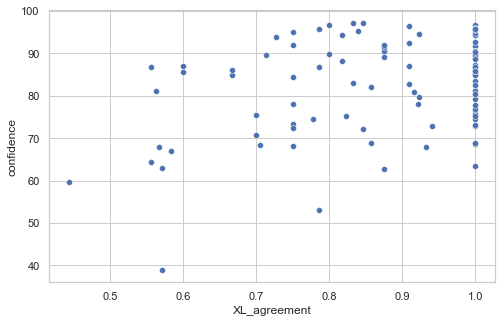

In [47]:
# Plot relationship between pLDDT and cross-link agreement
sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("whitegrid")
sns.scatterplot(x=intra_XL_counts['XL_agreement'], y=intra_XL_counts['confidence'])

## Determine overall XL agreement percentage for unrelaxed predictions

In [48]:
print('Total intramolecular XLs in proteins with AF predictions:', len(XLs_intra_nonred))
print('% XL Agreement: {}'.format((XLs_intra_nonred['af_distance'] <= XL_THRESHOLD).mean() * 100))

Total intramolecular XLs in proteins with AF predictions: 1225
% XL Agreement: 86.20408163265306


In [49]:
def is_low_confidence(protein):
    """Determine if the PLDDT score for a protein prediction is low confidence, below 70."""
    return intra_XL_counts[intra_XL_counts['Protein1'] == protein].iloc[0]['confidence'] < 70


XLs_intra_nonred['xl_violated'] = XLs_intra_nonred['af_distance'] > XL_THRESHOLD

XLs_intra_nonred['low_protein_confidence'] = None
XLs_intra_nonred['low_protein_confidence'] = XLs_intra_nonred.apply(lambda x: is_low_confidence(x['Protein1']), axis=1)

pd.crosstab(XLs_intra_nonred['xl_violated'], XLs_intra_nonred['low_protein_confidence'], normalize='index')

low_protein_confidence     False      True
xl_violated                               
False                   0.873106  0.126894
True                    0.698225  0.301775

## Compare cross-link agreement between different model predictions

In [50]:
intra_XL_counts['af_relaxed_XL_count'] = intra_XL_counts.apply(
    lambda x: get_af_xl_counts(x, XL_THRESHOLD, RELAXED_PDB_SUFFIX),
    axis=1)
intra_XL_counts['af_relaxed_ptm_XL_count'] = intra_XL_counts.apply(
    lambda x: get_af_xl_counts(x, XL_THRESHOLD, RELAXED_PTM_PDB_SUFFIX), axis=1)
intra_XL_counts['af_unrelaxed_ptm_XL_count'] = intra_XL_counts.apply(
    lambda x: get_af_xl_counts(x, XL_THRESHOLD, UNRELAXED_PTM_PDB_SUFFIX), axis=1)

### Compare Unrelaxed vs Relaxed for 10 most cross-linked proteins

In [51]:
top_10_XL_proteins = [
    'PRKG1',
    'EEF2',
    'MRNC57',
    'EMAP5/6-1',
    'I7MJ59',
    'BBC118',
    'FTT18',
    'EARS',
    'EMAP5/6-2',
    'Q23A15'
]

intra_XL_counts['relaxed_XL_agreement'] = intra_XL_counts['af_relaxed_XL_count'] / intra_XL_counts['XL_count']
intra_XL_counts['relaxed_vs_unrelaxed_diff'] = intra_XL_counts['af_relaxed_XL_count'] - intra_XL_counts['af_unrelaxed_XL_count']

# List differences in cross-link agreement between unrelaxed and relaxed
intra_XL_counts[intra_XL_counts['Protein1'].isin(top_10_XL_proteins) & (intra_XL_counts['relaxed_vs_unrelaxed_diff'] != 0)]

Empty DataFrame
Columns: [Protein1, XL_count, af_unrelaxed_XL_count, confidence, XL_agreement, af_relaxed_XL_count, af_relaxed_ptm_XL_count, af_unrelaxed_ptm_XL_count, relaxed_XL_agreement, relaxed_vs_unrelaxed_diff]
Index: []

### Compare Relaxed to Relaxed PTM for 13 example proteins with high violations

In [52]:
# 13 proteins with a high number of cross-link violations
example_proteins = [
    "EEF2",
    "MRNC57",
    "I7MJ59",
    "FTT18",
    "BBC118",
    "Q23A15",
    "KARS",
    "I7M6H8",
    "TRAF3IP1",
    "EIF4A",
    "SPEF2",
    "Q22MP6",
    "RPS0"
]

intra_XL_counts['relaxed_ptm_XL_agreement'] = intra_XL_counts['af_relaxed_ptm_XL_count'] / intra_XL_counts['XL_count']
intra_XL_counts['relaxed_ptm_vs_relaxed_diff'] = intra_XL_counts['af_relaxed_ptm_XL_count'] - intra_XL_counts['af_relaxed_XL_count']

# List differences in cross-link agreement between relaxed and relaxed PTM
intra_XL_counts[intra_XL_counts['Protein1'].isin(example_proteins) & (intra_XL_counts['relaxed_ptm_vs_relaxed_diff'] != 0)]

Protein1  XL_count  af_unrelaxed_XL_count  confidence  XL_agreement  \
61    SPEF2         9                      5   64.367416      0.555556   
64   Q22MP6         9                      4   59.571289      0.444444   

    af_relaxed_XL_count  af_relaxed_ptm_XL_count  af_unrelaxed_ptm_XL_count  \
61                  6.0                      5.0                          5   
64                  4.0                      3.0                          3   

    relaxed_XL_agreement  relaxed_vs_unrelaxed_diff  relaxed_ptm_XL_agreement  \
61              0.666667                        1.0                  0.555556   
64              0.444444                        0.0                  0.333333   

    relaxed_ptm_vs_relaxed_diff  
61                         -1.0  
64                         -1.0

In [53]:
intra_XL_counts[intra_XL_counts['relaxed_ptm_vs_relaxed_diff'].notnull()]['relaxed_ptm_vs_relaxed_diff'].mean()

-0.07142857142857142

### Compare Unrelaxed PTM to Relaxed PTM XL counts for example proteins

In [54]:
intra_XL_counts['unrelaxed_ptm_XL_agreement'] = intra_XL_counts['af_unrelaxed_ptm_XL_count'] / intra_XL_counts['XL_count']
intra_XL_counts['unrelaxed_ptm_vs_relaxed_ptm_diff'] = intra_XL_counts['af_unrelaxed_ptm_XL_count'] - intra_XL_counts['af_relaxed_ptm_XL_count']

# List differences in cross-link agreement between unrelaxed PTM and relaxed PTM
intra_XL_counts[intra_XL_counts['Protein1'].isin(example_proteins) & (intra_XL_counts['unrelaxed_ptm_vs_relaxed_ptm_diff'] != 0)]

Empty DataFrame
Columns: [Protein1, XL_count, af_unrelaxed_XL_count, confidence, XL_agreement, af_relaxed_XL_count, af_relaxed_ptm_XL_count, af_unrelaxed_ptm_XL_count, relaxed_XL_agreement, relaxed_vs_unrelaxed_diff, relaxed_ptm_XL_agreement, relaxed_ptm_vs_relaxed_diff, unrelaxed_ptm_XL_agreement, unrelaxed_ptm_vs_relaxed_ptm_diff]
Index: []

## Relationship between PAE and cross-link violation

### Ensure use of AlphaFold cross-link distances from unrelaxed PTM predictions

In [55]:
for protein in all_proteins:
    pdb_ca = read_protein_pdb(protein, UNRELAXED_PTM_PDB_SUFFIX)
    fill_xls_from_pdb(sanitize_protein(protein), XL_THRESHOLD, pdb_ca, XLs_intra_nonred)

### Plot cross-link violation percentages for bins of cross-links sorted by PAE

In [56]:
def get_pae_for_xl(xl, scored, aligned):
    """Read the Predicted Aligned Error (PAE) value for the crosslink, considering the column `scored` as the scored residue, and the column `aligned` as the aligned residue."""
    pae = read_protein_pae(xl['Protein1'])
    return pae[xl[scored] - 1, xl[aligned] - 1]

# Calculate average PAE for each cross-link
XLs_intra_nonred['pae_res1'] = XLs_intra_nonred.apply(lambda xl: get_pae_for_xl(xl, 'newRes1', 'newRes2'), axis=1)
XLs_intra_nonred['pae_res2'] = XLs_intra_nonred.apply(lambda xl: get_pae_for_xl(xl, 'newRes2', 'newRes1'), axis=1)
XLs_intra_nonred['pae_avg'] = XLs_intra_nonred.apply(lambda xl: (xl['pae_res1'] + xl['pae_res2']) / 2, axis=1)

XLs_with_pae = XLs_intra_nonred[XLs_intra_nonred['pae_avg'].notnull()]
XLs_with_pae

Unnamed: 0     Id   Score Protein1  PepPos1                    PepSeq1  \
0             20     21  396.55     ILS1      935           EYNKDLKAAAGNLSAK   
1             70     71  338.56    CDC27      742                 SQKEIEDQKK   
2             75     76  335.56    IDP2       345             AKLDNNKELDLFCK   
3            110    111  324.58   I7LUZ1      315  VICILDKPIPGTKDIPSVQIIIPQR   
4            247    248  299.14   Q234E6      487           AQVVEQSLEKHIQNEK   
...          ...    ...     ...      ...      ...                        ...   
1220       19345  19346  138.44   IFT172      556               QLYLYNIKTQTK   
1221       19355  19356  119.83   IFT172      206      SNKSQVMYSTDSYVVSLAACK   
1222       19378  19379   84.75      DLD       43              AGQLGLKTACVEK   
1223       19400  19401  132.50      DLD      127                NKVDYFVGTGR   
1224       19420  19421   94.69   IFT172     1174                   MAQKAIHK   

      LinkPos1 Protein2  PepPos2              PepSeq2  ...  Res1  Res2  \
0            7     ILS1      921          AIPNHKLLGQK  ...   941   926   
1            3    CDC27      752             KLDEELLR  ...   744   752   
2            7    IDP2       408           KNLVAAKSNL  ...   351   414   
3           13   I7LUZ1      128  VPANDKEALQSDLMGLLEK  ...   327   133   
4           10   Q234E6      603             SKAGTVTR  ...   496   604   
...        ...      ...      ...                  ...  ...   ...   ...   
1220         8   IFT172      496           LNYHSVKQTK  ...   563   502   
1221         3   IFT172      199              VKSGILR  ...   208   200   
1222         7      DLD      127          NKVDYFVGTGR  ...    49   128   
1223         2      DLD      119             GIESLFKK  ...   128   125   
1224         4   IFT172     1182              KPDVHLK  ...  1177  1182   

      newRes1  newRes2  af_distance  xl_violated  low_protein_confidence  \
0         941      926    11.374091        False                   False   
1         752      744    15.113780        False                    True   
2         414      351    13.137171        False                   False   
3         327      133    17.569451        False                   False   
4         604      496    17.662957        False                   False   
...       ...      ...          ...          ...                     ...   
1220      563      502    15.271272        False                   False   
1221      208      200    10.020496        False                   False   
1222      128       49     7.821404        False                   False   
1223      128      125     4.923555        False                   False   
1224     1182     1177     8.825150        False                   False   

       pae_res1   pae_res2   pae_avg  
0      2.257202   1.997203  2.127202  
1      5.936815   5.910926  5.923871  
2      6.109260   3.186682  4.647971  
3      4.221106   3.333841  3.777473  
4     10.020634   5.955312  7.987973  
...         ...        ...       ...  
1220   6.331279  10.455758  8.393519  
1221   1.935176   2.407195  2.171186  
1222   1.283425   1.276212  1.279819  
1223   0.918198   0.871551  0.894875  
1224   2.966324   3.430054  3.198189  

[1225 rows x 21 columns]

In [57]:
# Split cross-links into equal bins, sorted by PAE
XLs_with_pae.loc[:, 'bin'] = pd.qcut(XLs_with_pae['pae_avg'], 49)
XLs_with_pae['bin'].value_counts()

(0.814, 1.091]      25
(3.555, 3.83]       25
(4.137, 4.491]      25
(4.491, 4.853]      25
(4.853, 5.057]      25
(5.057, 5.45]       25
(5.45, 5.867]       25
(5.867, 6.332]      25
(6.332, 6.692]      25
(6.692, 7.171]      25
(7.171, 7.996]      25
(7.996, 8.528]      25
(8.528, 9.551]      25
(9.551, 10.318]     25
(10.318, 11.801]    25
(11.801, 13.157]    25
(13.157, 14.821]    25
(14.821, 16.69]     25
(16.69, 17.998]     25
(17.998, 20.061]    25
(20.061, 22.681]    25
(22.681, 25.128]    25
(25.128, 27.986]    25
(3.83, 4.137]       25
(3.36, 3.555]       25
(1.091, 1.265]      25
(3.178, 3.36]       25
(1.265, 1.354]      25
(1.354, 1.451]      25
(1.451, 1.546]      25
(1.546, 1.605]      25
(1.605, 1.654]      25
(1.654, 1.701]      25
(1.701, 1.766]      25
(1.766, 1.843]      25
(1.843, 1.898]      25
(1.898, 1.998]      25
(1.998, 2.078]      25
(2.078, 2.169]      25
(2.169, 2.243]      25
(2.243, 2.325]      25
(2.325, 2.446]      25
(2.446, 2.554]      25
(2.554, 2.6

In [58]:
# What value of PAE is the first violation?
lowest_pae_violation = XLs_with_pae[XLs_with_pae['xl_violated']]['pae_avg'].min()
lowest_pae_violation

3.510152816772461

In [59]:
# What is the PAE just before the first violation?
XLs_with_pae[XLs_with_pae['pae_avg'] < lowest_pae_violation]['pae_avg'].max()

3.49104642868042

In [60]:
def pop_std(x):
    return x.std(ddof=0)

# Calculate percent of cross-links violated for each bin
pae_vs_violations = XLs_with_pae.groupby(['bin'], as_index=False).agg({'pae_avg': ['mean', pop_std], 'xl_violated': 'mean'})
pae_vs_violations.columns = ['bin', 'pae_avg', 'pae_std', 'xl_violated']
pae_vs_violations

bin    pae_avg   pae_std  xl_violated
0     (0.814, 1.091]   0.949293  0.065925         0.00
1     (1.091, 1.265]   1.180143  0.048536         0.00
2     (1.265, 1.354]   1.315078  0.023461         0.00
3     (1.354, 1.451]   1.405875  0.029232         0.00
4     (1.451, 1.546]   1.495961  0.028308         0.00
5     (1.546, 1.605]   1.572665  0.019429         0.00
6     (1.605, 1.654]   1.626066  0.012756         0.00
7     (1.654, 1.701]   1.677433  0.014339         0.00
8     (1.701, 1.766]   1.731508  0.018300         0.00
9     (1.766, 1.843]   1.806160  0.024513         0.00
10    (1.843, 1.898]   1.866804  0.016506         0.00
11    (1.898, 1.998]   1.951229  0.030281         0.00
12    (1.998, 2.078]   2.040702  0.025267         0.00
13    (2.078, 2.169]   2.126191  0.030366         0.00
14    (2.169, 2.243]   2.199421  0.025766         0.00
15    (2.243, 2.325]   2.280285  0.024398         0.00
16    (2.325, 2.446]   2.379682  0.031668         0.00
17    (2.446, 2.554]   2.492903  0.036491         0.00
18    (2.554, 2.673]   2.607801  0.034409         0.00
19    (2.673, 2.756]   2.719902  0.024285         0.00
20    (2.756, 2.881]   2.810189  0.035750         0.00
21    (2.881, 3.022]   2.963006  0.039189         0.00
22    (3.022, 3.178]   3.084002  0.044142         0.00
23     (3.178, 3.36]   3.276388  0.049132         0.00
24     (3.36, 3.555]   3.462236  0.057148         0.04
25     (3.555, 3.83]   3.680866  0.086926         0.00
26     (3.83, 4.137]   3.981702  0.084581         0.04
27    (4.137, 4.491]   4.289195  0.112110         0.12
28    (4.491, 4.853]   4.707668  0.099066         0.00
29    (4.853, 5.057]   4.935487  0.057368         0.08
30     (5.057, 5.45]   5.291276  0.110304         0.12
31     (5.45, 5.867]   5.637037  0.119381         0.16
32    (5.867, 6.332]   6.119934  0.150047         0.12
33    (6.332, 6.692]   6.492908  0.096206         0.12
34    (6.692, 7.171]   6.893013  0.147361         0.08
35    (7.171, 7.996]   7.549626  0.258564         0.12
36    (7.996, 8.528]   8.297040  0.174855         0.20
37    (8.528, 9.551]   9.095088  0.294842         0.08
38   (9.551, 10.318]   9.876118  0.231142         0.08
39  (10.318, 11.801]  11.136947  0.390761         0.24
40  (11.801, 13.157]  12.534209  0.412430         0.36
41  (13.157, 14.821]  14.126761  0.495581         0.24
42   (14.821, 16.69]  15.848006  0.514094         0.32
43   (16.69, 17.998]  17.375107  0.454695         0.68
44  (17.998, 20.061]  18.997029  0.608895         0.52
45  (20.061, 22.681]  21.222790  0.753025         0.60
46  (22.681, 25.128]  23.909028  0.707063         0.64
47  (25.128, 27.986]  26.877052  0.784104         0.84
48  (27.986, 30.187]  28.736333  0.539159         0.96

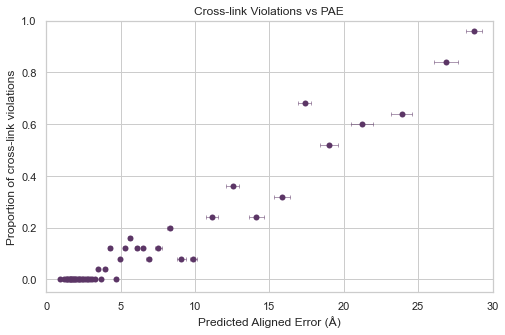

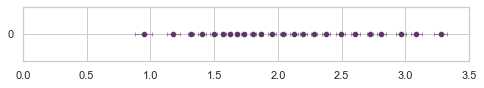

In [61]:
# Plot
title = 'Cross-link Violations vs PAE'
sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("whitegrid")
ax = sns.scatterplot(x='pae_avg', y='xl_violated', data=pae_vs_violations, color = '#5c3666', linewidth=0)
plt.errorbar(x='pae_avg', y='xl_violated', xerr='pae_std', data=pae_vs_violations, color = '#5c3666', ls='none', elinewidth=0.5, capsize=2, capthick=0.5)
ax.set(title=title, xlabel='Predicted Aligned Error (Å)', ylabel='Proportion of cross-link violations')
plt.xlim(0, 30)
plt.ylim(-0.05, 1)
plt.legend([],[], frameon=False)

plt.savefig("figures/{}.svg".format(title))
plt.show()

# Zoom on overlapping points
sns.set(rc={'figure.figsize':(8,1)})
sns.set_style("whitegrid")
ax = sns.scatterplot(x='pae_avg', y='xl_violated', data=pae_vs_violations, color = '#5c3666')
plt.errorbar(x='pae_avg', y='xl_violated', xerr='pae_std', data=pae_vs_violations, color = '#5c3666', ls='none', elinewidth=0.5, capsize=2, capthick=0.5)
ax.set(xlabel='', ylabel='')
ax.set_yticks([0])
plt.xlim(0.0, 3.5)
plt.ylim(-0.001, 0.001)
plt.legend([],[], frameon=False)

plt.savefig("figures/{} Zoom.svg".format(title))
plt.show()

## Analyze PAE pattern for 14 example proteins to extract cohesive regions

### Ensure use of AlphaFold cross-link distances from relaxed PTM predictions

In [62]:
for protein in example_proteins:
    pdb_ca = read_protein_pdb(protein, RELAXED_PTM_PDB_SUFFIX)
    fill_xls_from_pdb(sanitize_protein(protein), XL_THRESHOLD, pdb_ca, XLs_intra_nonred)

## Identify cohesive regions from PAE matrix using watershed segmentation

In [63]:
# Custom colormap where value 0 is black
regions_cmap = plt.cm.get_cmap("viridis").copy()
regions_cmap.set_bad(color='black')


def make_symmetric(pae):
    """Average the matrix with its transpose to make it symmetric."""
    pae = np.array(pae)
    return (pae + pae.transpose()) / 2


def make_region_mat_from_labels(region_labels):
    """Construct a matrix from the list region_labels where (i,j) is assigned a non-zero label only if that label is present at both positions i and j within region_labels."""
    region_labels = np.asarray(region_labels)
    regions_mat = np.array([i if i == j else 0 for i in region_labels for j in region_labels]).reshape(
        region_labels.shape[0], region_labels.shape[0])
    return np.ma.masked_where(regions_mat == 0, regions_mat)


def plot_watershed_process(name, pae, image, denoised, gradient, markers, labels, pretrimmed_region_labels, region_labels):
    """Plot each intermediate matrix from the watershed segmentation process."""
    fig, axes = plt.subplots(nrows=1, ncols=9, figsize=(36, 4), sharex=True, sharey=True)
    fig.patch.set_facecolor('white')
    fig.suptitle(name + ' Watershed Segmentation')

    ax = axes.ravel()

    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title("Predicted Aligned Error")
    ax[0].set_xlabel("Residue")
    ax[0].set_ylabel("Residue")

    ax[1].imshow(image, cmap=plt.cm.gray)
    ax[1].set_title("Symmetric")

    ax[2].imshow(denoised, cmap=plt.cm.gray)
    ax[2].set_title("Denoised")

    ax[3].imshow(gradient, cmap=plt.cm.nipy_spectral)
    ax[3].set_title("Local Gradient")

    ax[4].imshow(markers, cmap=regions_cmap)
    ax[4].set_title("Markers")

    ax[5].imshow(labels, cmap=regions_cmap)
    ax[5].set_title("Segmented")

    pretrimmed_regions_mat = make_region_mat_from_labels(pretrimmed_region_labels)

    ax[6].imshow(pretrimmed_regions_mat, cmap=regions_cmap)
    ax[6].set_title("Regions Before Trimming")

    regions_mat = make_region_mat_from_labels(region_labels)

    ax[7].imshow(regions_mat, cmap=regions_cmap)
    ax[7].set_title("Regions")

    img_pae_original = (pae - np.min(pae)) / (np.max(pae) - np.min(pae))

    ax[8].imshow(regions_mat, cmap=regions_cmap, alpha=1 - img_pae_original)
    ax[8].set_title("Original with Regions Overlayed")
    ax[8].set_xlabel("Scored Residue")
    ax[8].set_ylabel("Aligned Residue")

    for one_ax in ax:
        one_ax.grid(False)

    fig.tight_layout()
    fig.savefig("figures/watershed/{}.svg".format(sanitize_protein(name)), dpi = 300)
    plt.show()


def predict_watershed(name, pae, denoise_footprint, marker_footprint, marker_threshold, gradient_footprint,
                      repeat_denoise, remove_thin_regions, region_edge_threshold):
    """Label all residues in the same well-predicted regions based on watershed segmentation of the PAE matrix."""

    # Make symmetric - easier to determine segmentation
    pae = make_symmetric(pae)

    img_pae = (pae - np.min(pae)) / (np.max(pae) - np.min(pae))
    image = img_as_ubyte(img_pae)

    # Denoise potentially multiple times
    denoised = rank.median(image, square(denoise_footprint))
    if repeat_denoise > 1:
        for i in range(0, repeat_denoise):
            denoised = rank.median(denoised, square(denoise_footprint))

    # Define markers to start basins as areas with low local gradient
    markers = rank.gradient(denoised, square(marker_footprint)) < marker_threshold
    markers = ndi.label(markers)[0]

    # Local gradient to use when filling watershed segments
    gradient = rank.gradient(denoised, square(gradient_footprint))

    # Process the watershed segmentation
    labels = watershed(gradient, markers)

    # Extract initial region labels as the diagonal
    diagonal = np.diagonal(np.array(labels))
    region_labels = diagonal.copy()

    # Remove labels in segments which are less than 2*region_edge_threshold wide on the diagonal
    if remove_thin_regions:
        for i in range(0, len(region_labels)):
            label = region_labels[i]
            before = 0
            after = 0
            if i >= region_edge_threshold:
                before = labels[i, i - region_edge_threshold]
            if i + region_edge_threshold < region_labels.shape[0]:
                after = labels[i, i + region_edge_threshold]
            if before != label and after != label:
                region_labels[i] = 0

    regions_count = np.bincount(region_labels)
    region_count_threshold = 30
    segment_background_labels = []
    # If there are "background" non-region labels, mark as 0
    if len(regions_count) > 1:
        segment_background_labels.append(labels[0, len(region_labels) - 1])
        segment_background_labels.append(labels[len(region_labels) - 1, 0])
    for i in range(0, len(region_labels)):
        if region_labels[i] in segment_background_labels:
            region_labels[i] = 0
        if regions_count[region_labels[i]] < region_count_threshold:
            region_labels[i] = 0

    # Fill empty gaps in labeled regions which were created by removing thin parts of segments
    # Also re-number labels starting from 1
    regions_counter = Counter(region_labels)
    fill_label = 0
    current_label = None
    for i in range(0, len(region_labels)):
        if region_labels[i] != 0:
            # Determine region label and count down to end of region
            if region_labels[i] != current_label:
                current_label = region_labels[i]
                fill_label += 1
            region_labels[i] = fill_label
            regions_counter[current_label] = regions_counter[current_label] - 1
            if regions_counter[current_label] == 0:
                current_label = None
        elif current_label is not None:
            # Fill in 0s with label
            region_labels[i] = fill_label

    plot_watershed_process(name, pae, image, denoised, gradient, markers, labels, diagonal, region_labels)

    return region_labels


def predict_watershed_for_protein(protein_with_parameters):
    """Read the PAE matrix for the protein and perform watershed segmentation with the given parameters."""
    (protein, denoise_footprint, marker_footprint, marker_threshold, gradient_footprint, repeat_denoise,
     remove_thin_regions, region_edge_threshold) = protein_with_parameters
    pae = read_protein_pae(protein)
    return predict_watershed(protein, pae, denoise_footprint, marker_footprint, marker_threshold, gradient_footprint,
                             repeat_denoise, remove_thin_regions, region_edge_threshold).tolist()


def predict_watershed_for_proteins(proteins_with_parameters):
    """Perform watershed segmentation for the proteins with the given parameters and return the determined region labels."""
    labels = {}
    for protein_with_parameters in proteins_with_parameters:
        labels[protein_with_parameters[0]] = predict_watershed_for_protein(protein_with_parameters)
    return labels


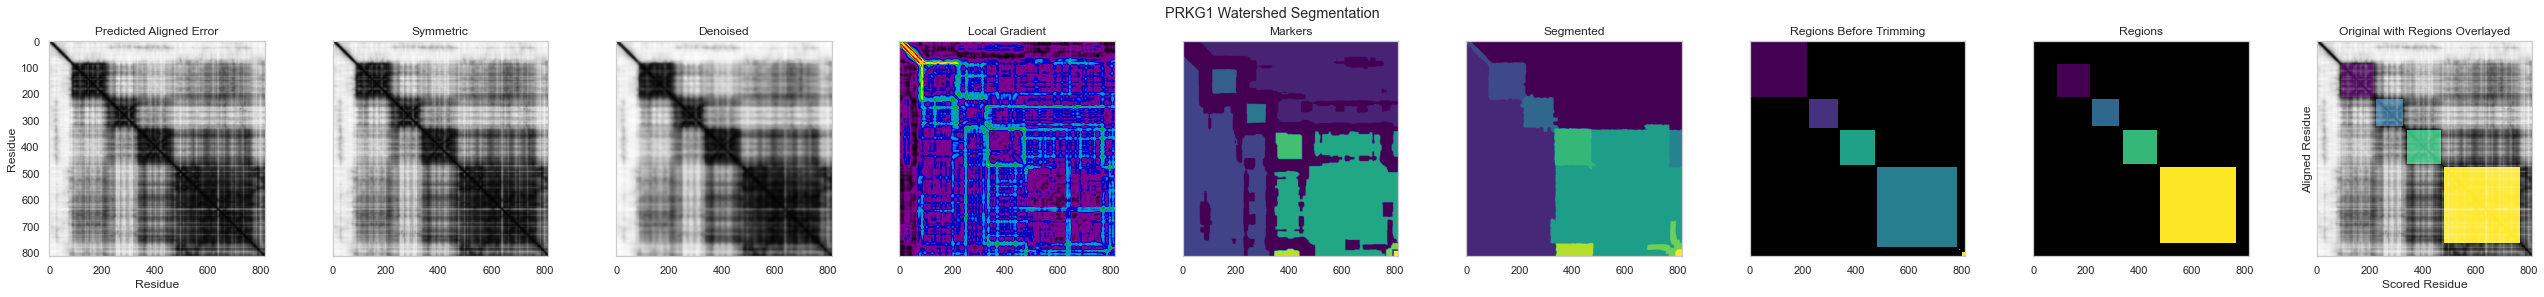

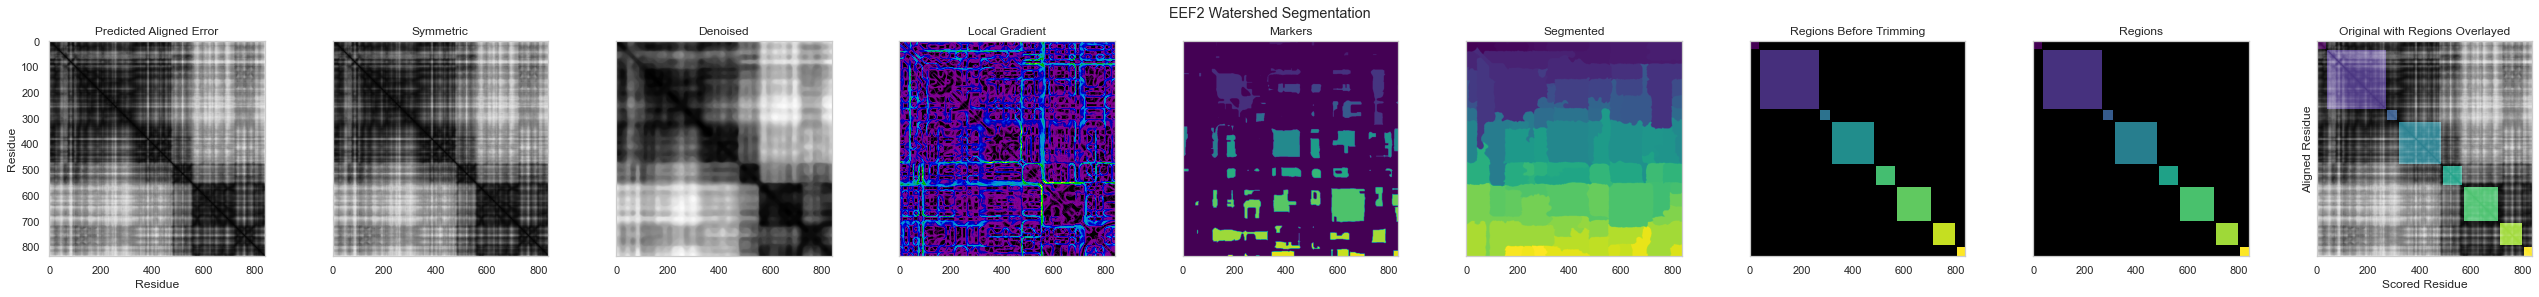

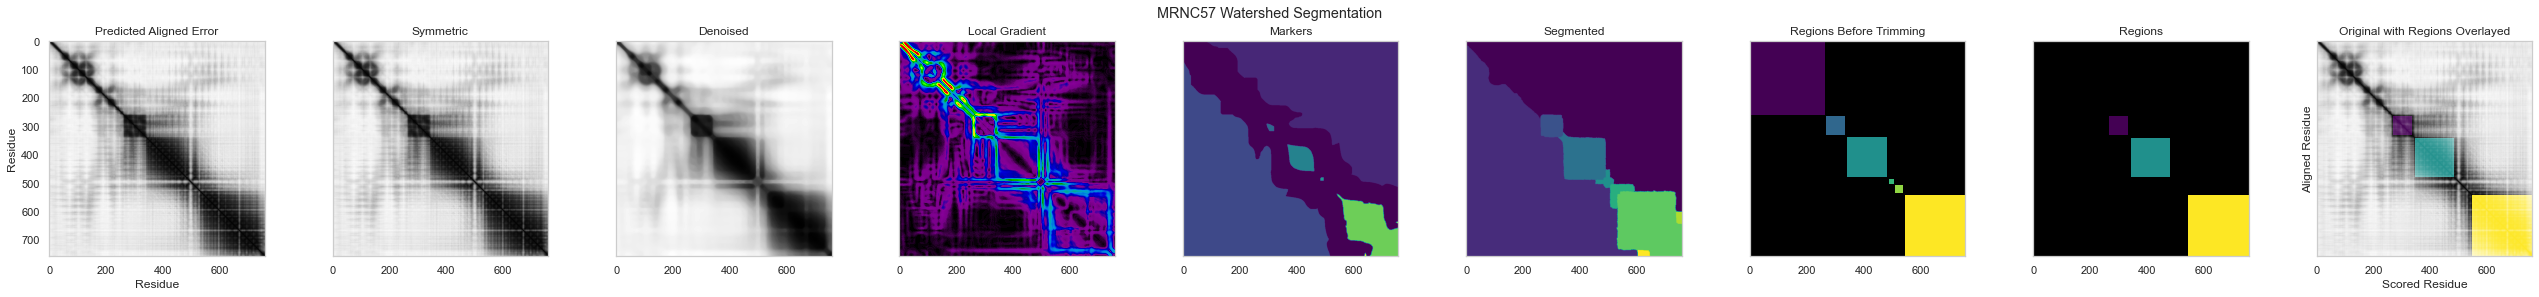

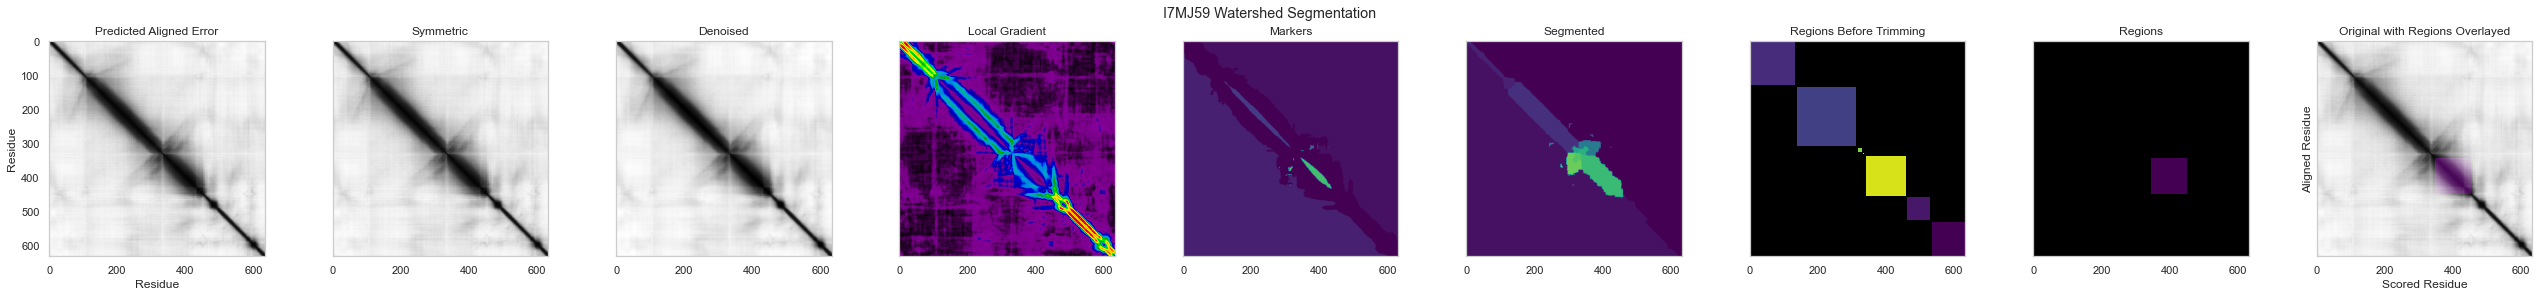

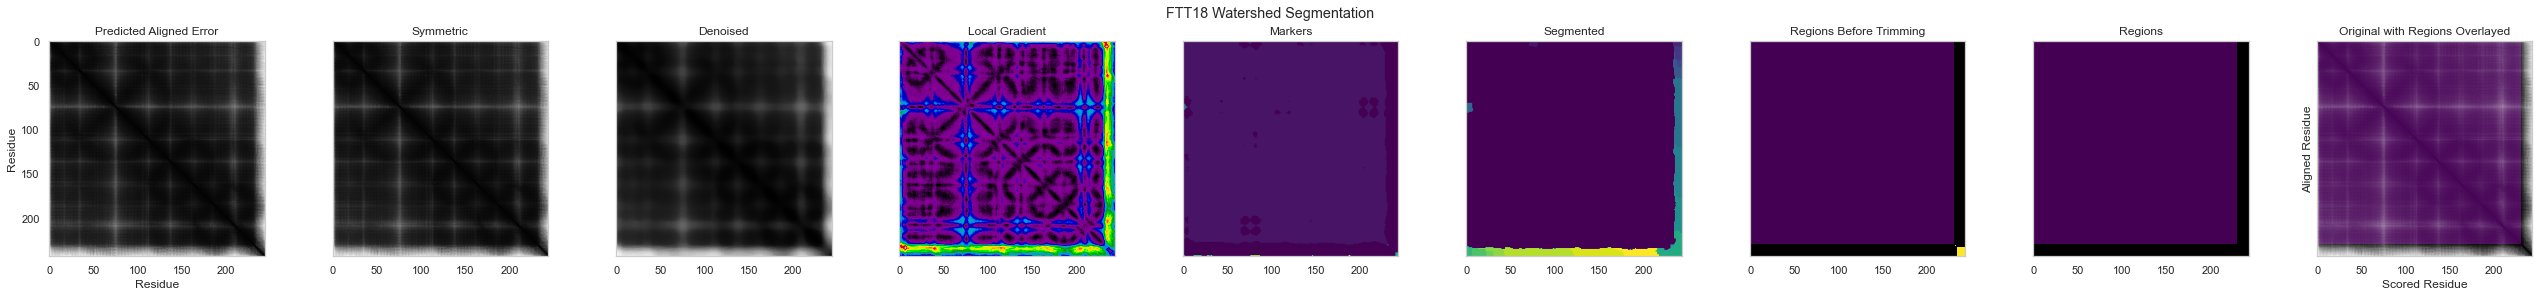

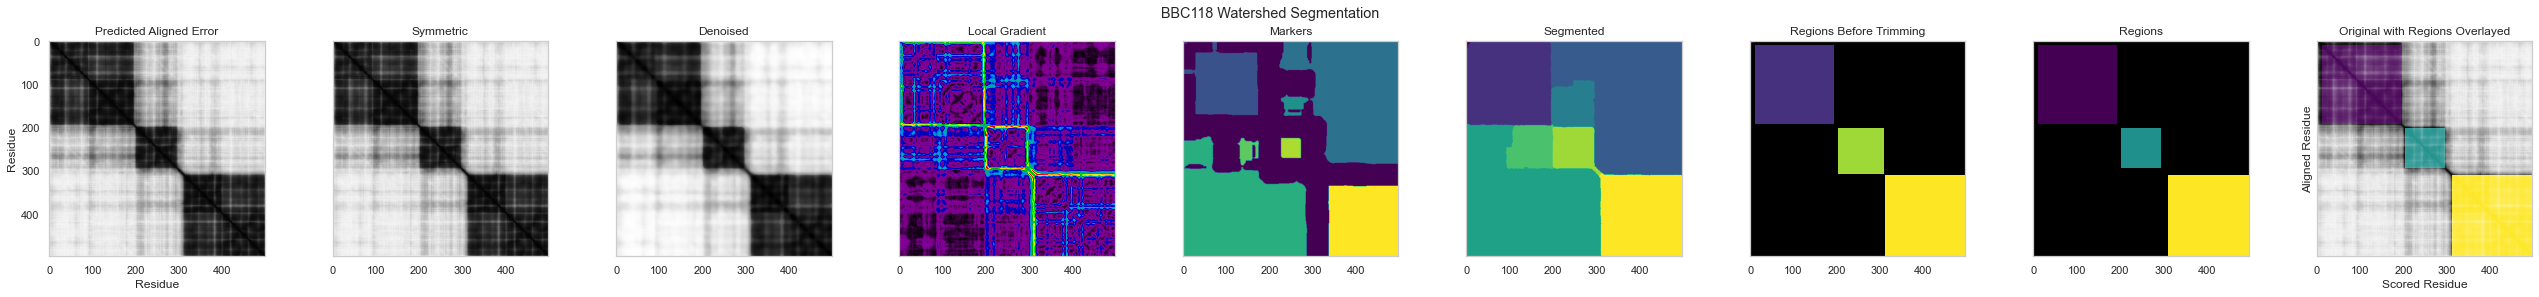

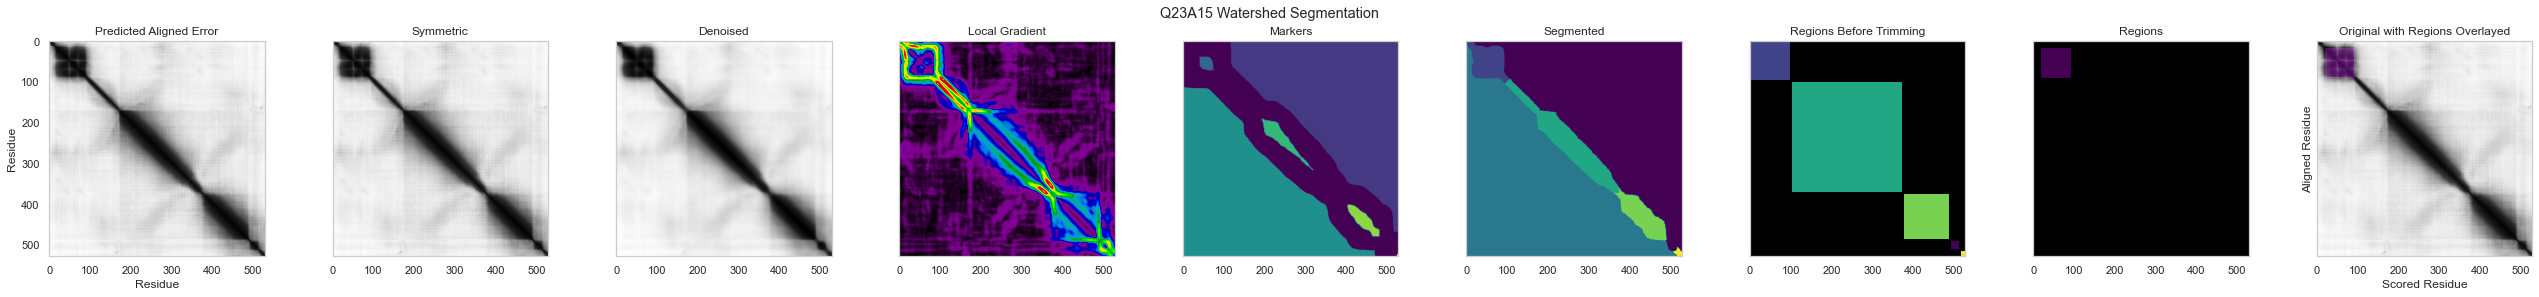

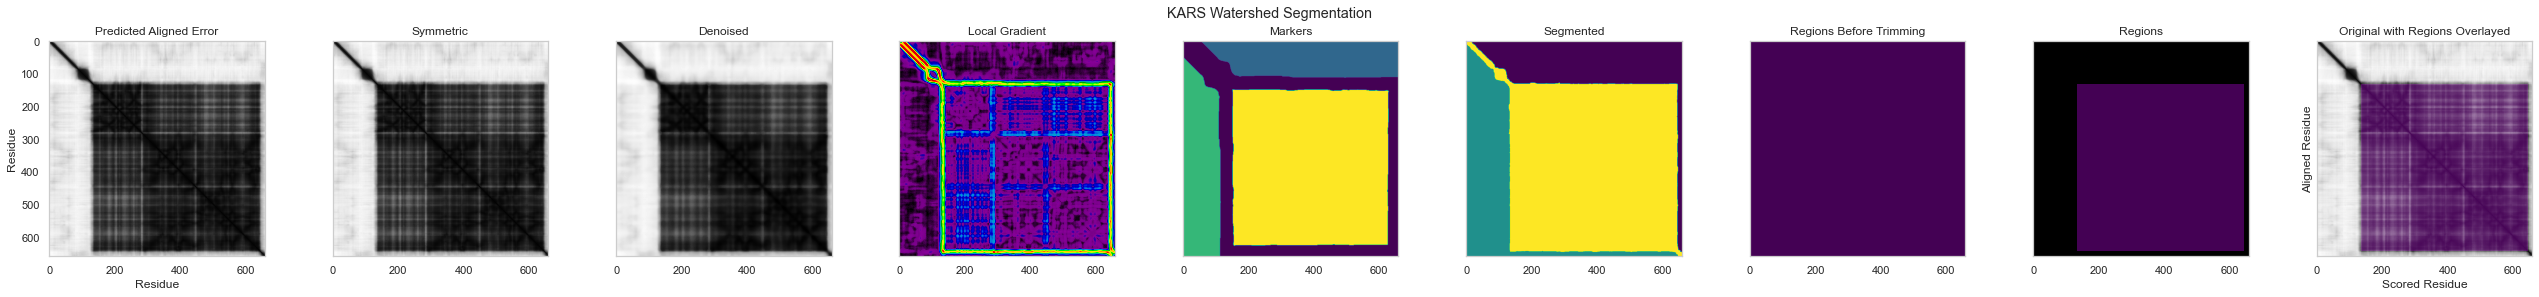

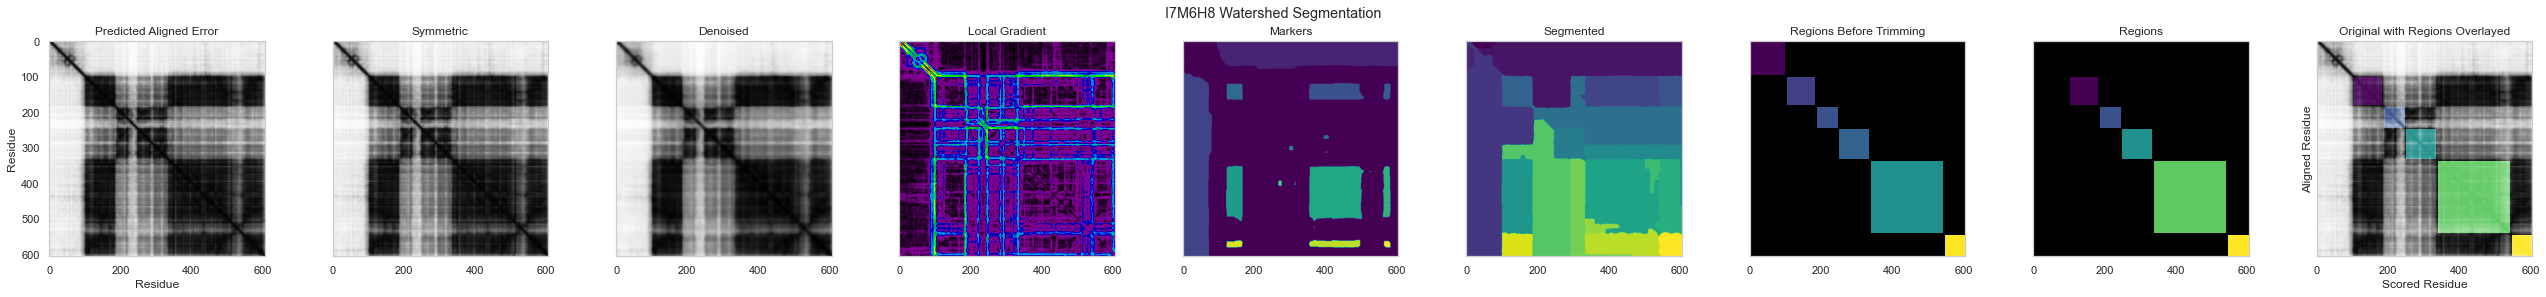

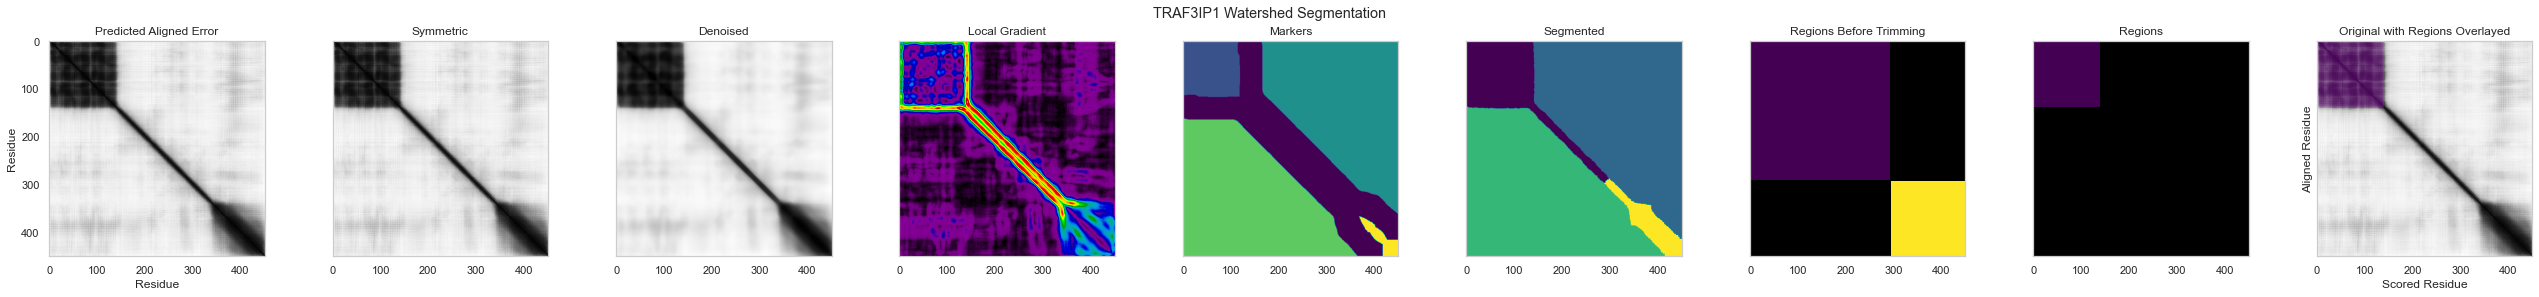

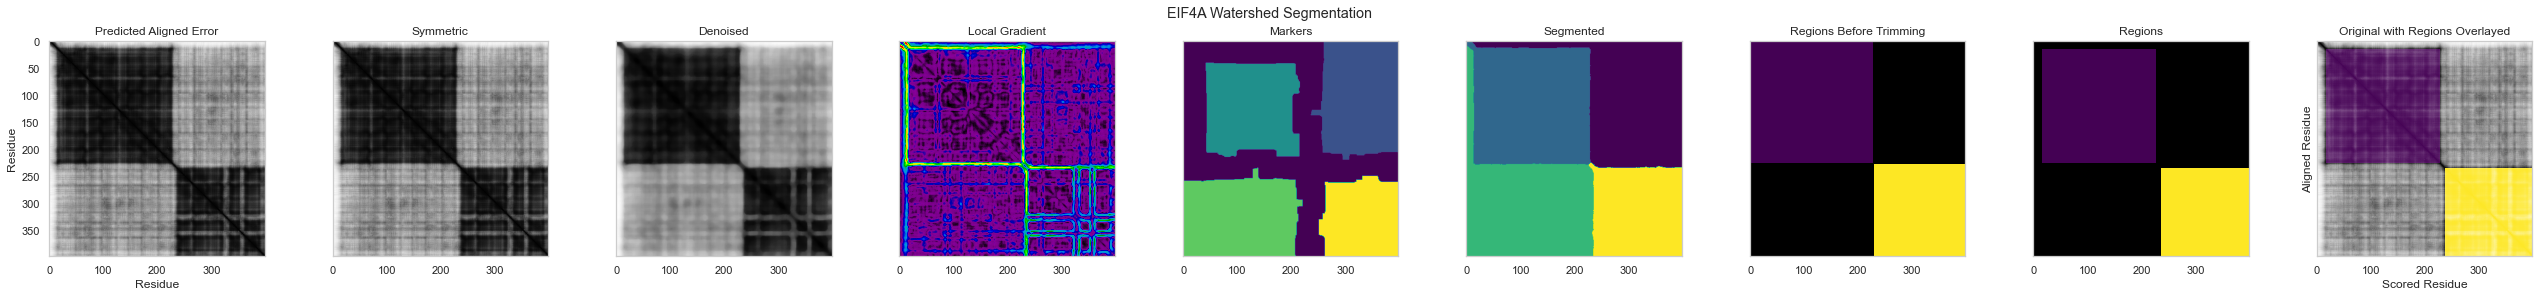

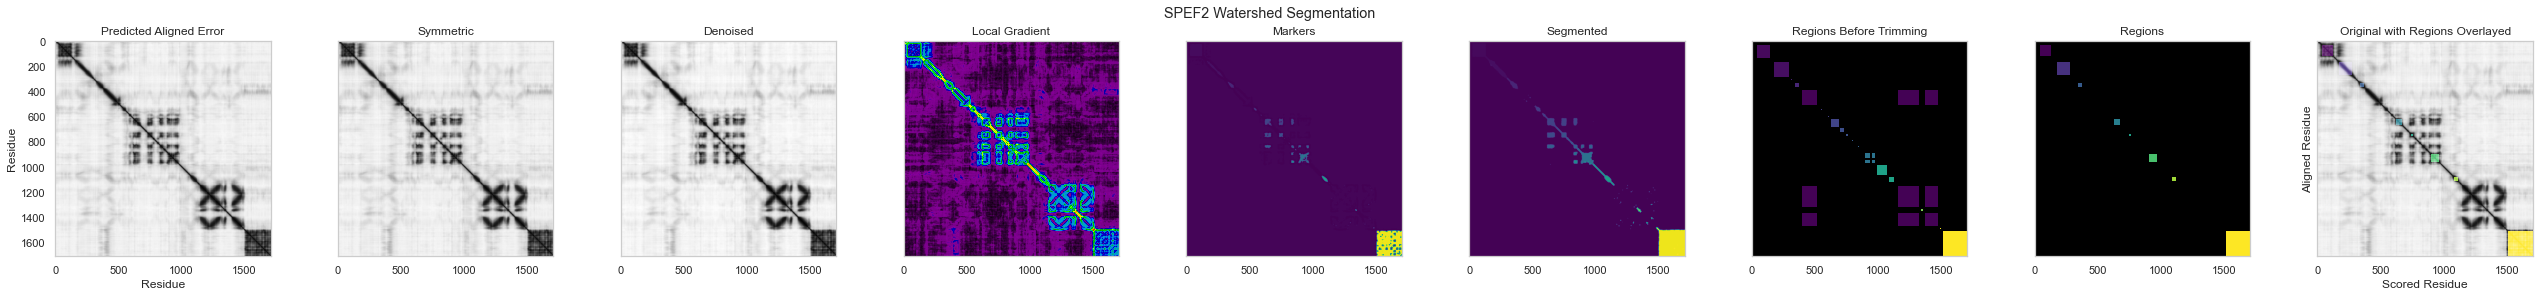

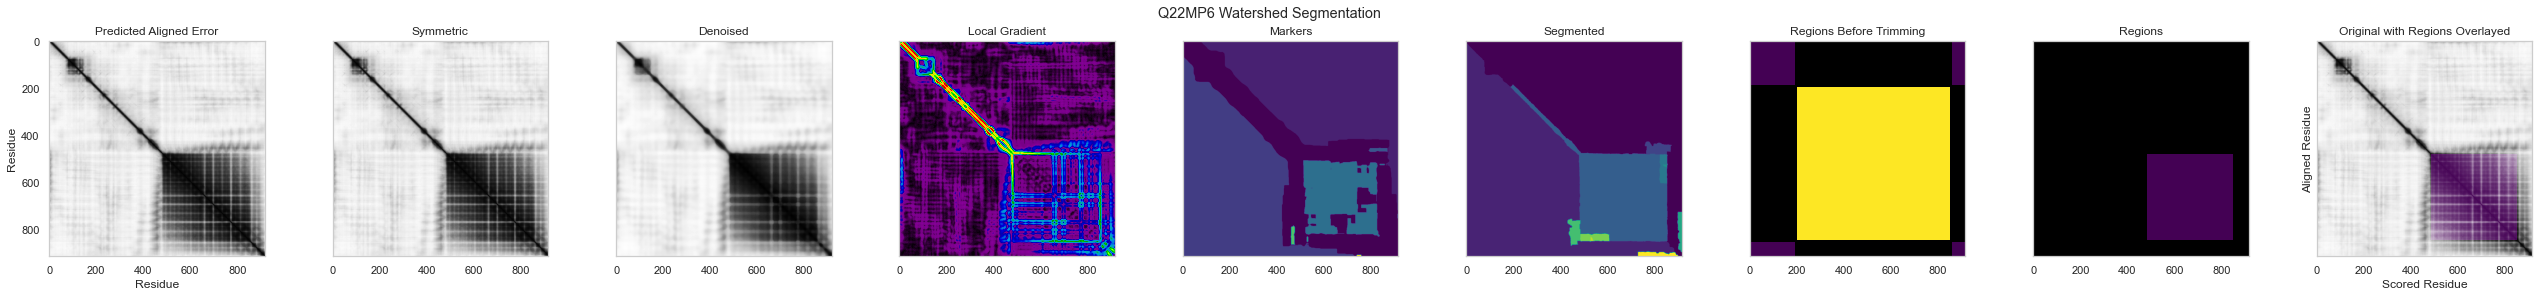

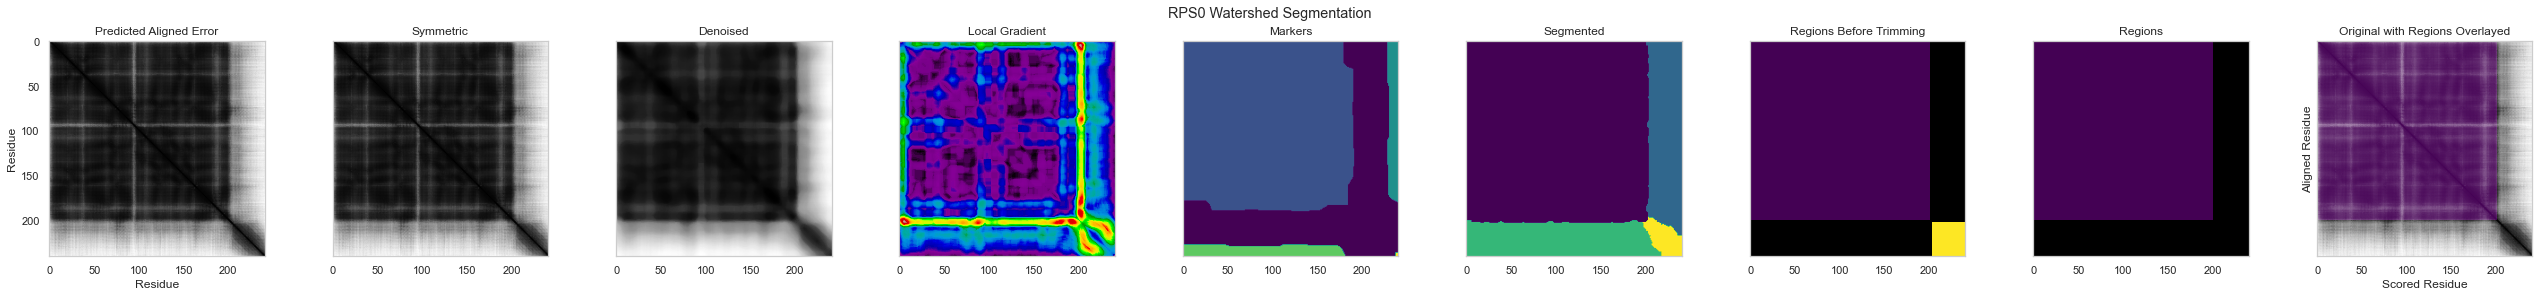

In [64]:
# Parameters:
# denoise_footprint, marker_footprint, marker_threshold, gradient_footprint, repeat_denoise, remove_thin_regions, region_edge_threshold
example_proteins_watershed_settings = [         # Subjective quality of regions
    ("PRKG1", 12, 50, 115, 10, 1, True, 20),    # good (used as example of watershed, not analysis)
    ("EEF2", 15, 40, 30, 3, 3, False, 5),       # okay
    ("MRNC57", 15, 65, 105, 10, 2, True, 50),   # okay
    ("I7MJ59", 5, 20, 50, 10, 1, True, 40),     # okay
    ("FTT18", 10, 10, 40, 4, 1, True, 40),      # good
    ("BBC118", 10, 50, 100, 5, 1, True, 20),    # good
    ("Q23A15", 10, 50, 150, 10, 1, True, 40),   # good
    ("KARS", 10, 45, 150, 10, 1, True, 40),     # good
    ("I7M6H8", 10, 40, 55, 5, 1, False, 20),    # okay
    ("TRAF3IP1", 10, 50, 150, 10, 1, True, 40), # good
    ("EIF4A", 10, 60, 150, 5, 1, True, 15),     # good
    ("SPEF2", 5, 10, 70, 10, 1, True, 20),      # bad
    ("Q22MP6", 15, 60, 95, 10, 1, True, 40),    # good
    ("RPS0", 10, 50, 150, 10, 1, True, 40)      # good
]

labels = predict_watershed_for_proteins(example_proteins_watershed_settings)

In [65]:
# Save watershed region labels for other visualizations
with open(PATH_WATERSHED_LABELS, 'w') as watershed_labels_out:
    json.dump(labels, watershed_labels_out)

### Corresponding proteins in Uniprot

[I7M6H8](https://www.uniprot.org/uniprot/I7M6H8)
* Domain (IMPDH) 104-600

[Q23A15](https://www.uniprot.org/uniprot/Q23A15)
* Disordered 1 - 20
* Disordered 93 - 157
* Compositional Bias (Polar residues) 96 - 141
* Disordered 242 - 278
* Disordered 324 - 364
* Disordered 395 - 441
* Coiled Coil 503 - 523

[Q22MP6](https://www.uniprot.org/uniprot/Q22MP6)
* Disordered 1-38
* Disordered 401 - 420
* Coiled Coil 156 - 176
* Domain (Protein Kinase) 116 - 455
* Repeat (TPR) 606 - 639

[I7MJ59](https://www.uniprot.org/uniprot/I7MJ59)
* Disordered 1-41
* Coiled Coil 119 - 139
* Coiled Coil 150 - 194
* Coiled Coil 203 - 237
* Coiled Coil 247 - 267
* Coiled Coil 332 - 362
* Disordered 496 - 515
* Disordered 614 - 633

## Classify satisfied or violated cross-links as intra-region or inter-region based on watershed results

In [66]:
def is_intraregion(region_labels, res1, res2):
    """Determine if the two residue positions are within the same non-background (non-zero) region"""
    return region_labels[res1 - 1] != 0 and region_labels[res1 - 1] == region_labels[res2 - 1]


# Re-calculate violated XLs based on the relaxed PTM distances
XLs_intra_nonred['xl_violated'] = XLs_intra_nonred['af_distance'] > XL_THRESHOLD
XLs_intra_nonred['is_intraregion'] = None

for protein in example_proteins:
    region_labels = labels[protein]
    XLs_intra_nonred['is_intraregion'] = XLs_intra_nonred.apply(
        lambda x: x['is_intraregion'] if x['Protein1'] != protein else is_intraregion(region_labels, x['newRes1'],
                                                                                      x['newRes2']), axis=1)

pd.crosstab(XLs_intra_nonred['xl_violated'], XLs_intra_nonred['is_intraregion'], normalize='index')

is_intraregion     False      True
xl_violated                       
False           0.398773  0.601227
True            0.898876  0.101124

In [67]:
pd.crosstab(XLs_intra_nonred['xl_violated'], XLs_intra_nonred['is_intraregion'])

is_intraregion  False  True
xl_violated                
False              65    98
True               80     9

In [68]:
XLs_intra_nonred[XLs_intra_nonred['xl_violated'] & XLs_intra_nonred['is_intraregion']]

Unnamed: 0     Id   Score Protein1  PepPos1              PepSeq1  \
52          3928   3929  188.13    FTT18       30       KVVQTGQELSVEER   
168         8086   8087  145.06   I7MJ59      413           YKDFLDQQYK   
239         9948   9949  128.28   I7MJ59      412          KYKDFLDQQYK   
277        10846  10847  120.09     KARS      145  CKAVQDLMTTGKPYPYPHK   
310        11375  11376  115.38     KARS      147    AVQDLMTTGKPYPYPHK   
404        12694  12695  100.93   I7MJ59      342           LQSEIDKIQR   
861        16531  16532   44.20    FTT18       71     EESKGSKHLDLLTNYK   
1141       18701  18702  301.35    FTT18        6      EENIYMGKISEQTER   
1173       18759  18760  264.28    FTT18        6      EENIYMGKISEQTER   

      LinkPos1 Protein2  PepPos2          PepSeq2  ...  Res2  newRes1  \
52           1    FTT18       63     SISAIQQKEESK  ...    70       70   
168          2   I7MJ59      437          NEKGLNR  ...   439      439   
239          1   I7MJ59      437          NEKGLNR  ...   439      439   
277          2     KARS      578       KIFVQQIEEK  ...   578      578   
310         10     KARS      546         SKPNVTER  ...   547      547   
404          7   I7MJ59      379         NLKEQQVK  ...   381      381   
861          4    FTT18        6  EENIYMGKISEQTER  ...    13       74   
1141         8    FTT18       63     SISAIQQKEESK  ...    70       70   
1173         8    FTT18       75     GSKHLDLLTNYK  ...    77       77   

      newRes2  af_distance  xl_violated  low_protein_confidence   pae_res1  \
52         30    42.794643         True                   False   4.961131   
168       414    36.827364         True                    True   6.220132   
239       412    38.631004         True                    True   7.030150   
277       146    70.745774         True                   False   7.529932   
310       156    81.000601         True                   False   9.766783   
404       348    50.174561         True                    True   8.669635   
861        13    46.741148         True                   False   8.557825   
1141       13    40.742738         True                   False   4.921982   
1173       13    45.659468         True                   False  10.436308   

       pae_res2    pae_avg  is_intraregion  
52     3.805740   4.383436            True  
168    5.286342   5.753237            True  
239    6.479436   6.754793            True  
277    8.747476   8.138704            True  
310   14.957903  12.362343            True  
404    6.828403   7.749019            True  
861    4.540651   6.549238            True  
1141   3.695716   4.308849            True  
1173   4.610078   7.523193            True  

[9 rows x 22 columns]

## Differences in predictions of EEF2 structure from 5 AlphaFold models

In [69]:
eef2_xls = XLs_intra_nonred[XLs_intra_nonred['Protein1'] == 'EEF2']
pd.crosstab(eef2_xls['xl_violated'], eef2_xls['is_intraregion'], normalize='index')

is_intraregion  False  True
xl_violated                
False            0.44  0.56
True             1.00  0.00

## Produce Figures

In [70]:
def plot_pae_xls(protein, ax, fig):
    """Plot PAE values as a heatmap with an overlay of satisfied and violated cross-links, with different colors for intra- or inter-region."""
    pae = read_protein_pae(protein)

    protein_xls = XLs_intra_nonred.loc[XLs_intra_nonred['Protein1'] == protein]

    protein_xls_agreed_interregion = protein_xls[(protein_xls['af_distance'] <= XL_THRESHOLD) & (protein_xls['is_intraregion'] == False)]
    protein_xls_agreed_intraregion = protein_xls[(protein_xls['af_distance'] <= XL_THRESHOLD) & (protein_xls['is_intraregion'] == True)]
    protein_xls_missed_interregion = protein_xls[(protein_xls['af_distance'] > XL_THRESHOLD) & (protein_xls['is_intraregion'] == False)]
    protein_xls_missed_intraregion = protein_xls[(protein_xls['af_distance'] > XL_THRESHOLD) & (protein_xls['is_intraregion'] == True)]

    im = ax.imshow(pae, cmap='gray', alpha=0.5, vmin=0, vmax=31)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, ticks=[0, 30])
    cbar.ax.set_ylabel('PAE (Å)', rotation=270, position=(10, 0.5))
    ax.scatter(protein_xls_agreed_interregion['newRes1'] - 1, protein_xls_agreed_interregion['newRes2'] - 1, marker='o', facecolor='none',
               edgecolor='darkblue', linewidths=2)
    ax.scatter(protein_xls_agreed_intraregion['newRes1'] - 1, protein_xls_agreed_intraregion['newRes2'] - 1, marker='o', facecolor='none',
               edgecolor='cyan', linewidths=2)
    ax.scatter(protein_xls_missed_interregion['newRes1'] - 1, protein_xls_missed_interregion['newRes2'] - 1, marker='x', c='darkred',
               linewidths=2)
    ax.scatter(protein_xls_missed_intraregion['newRes1'] - 1, protein_xls_missed_intraregion['newRes2'] - 1, marker='x', c='magenta',
               linewidths=2)

    ax.set_title('PAE and Cross-links within ' + str(XL_THRESHOLD) + 'Å')
    ax.set_xlabel('Scored residue')
    ax.set_ylabel('Aligned residue')
    ax.grid(False)

In [71]:
def plot_watershed_regions(pae, region_labels, ax, fig):
    """Plot the watershed regions overlayed on the original PAE matrix as a heatmap."""
    img_pae_original = (pae - np.min(pae)) / (np.max(pae) - np.min(pae))

    regions_mat = make_region_mat_from_labels(region_labels)

    original_im = ax.imshow(img_pae_original, cmap='gray', vmin=0, vmax=31)
    cbar = fig.colorbar(original_im, ax=ax, fraction=0.046, pad=0.04, ticks=[0, 30])
    cbar.ax.set_ylabel('PAE (Å)', rotation=270, position=(10, 0.5))
    original_im.set_visible(False)

    ax.imshow(regions_mat, cmap=regions_cmap, alpha=1 - img_pae_original)
    ax.set_facecolor('white')
    ax.set_title("Watershed Predicted Regions")
    ax.set_xlabel("Scored Residue")
    ax.set_ylabel("Aligned Residue")
    ax.grid(False)
    return original_im

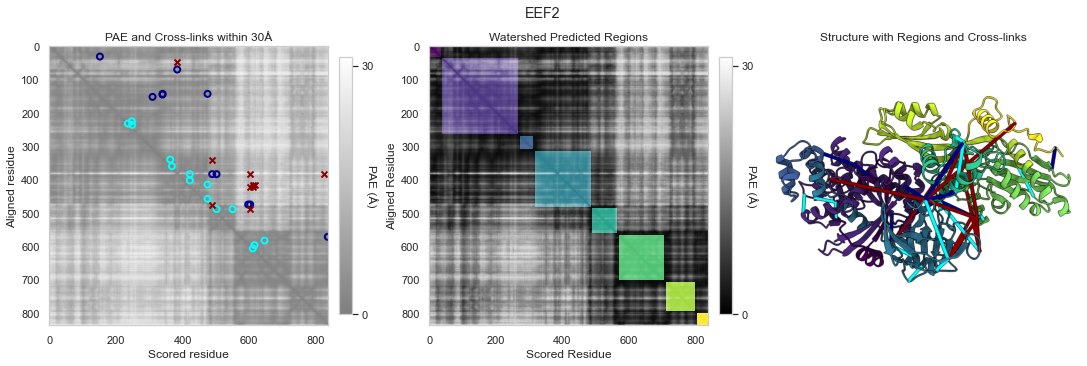

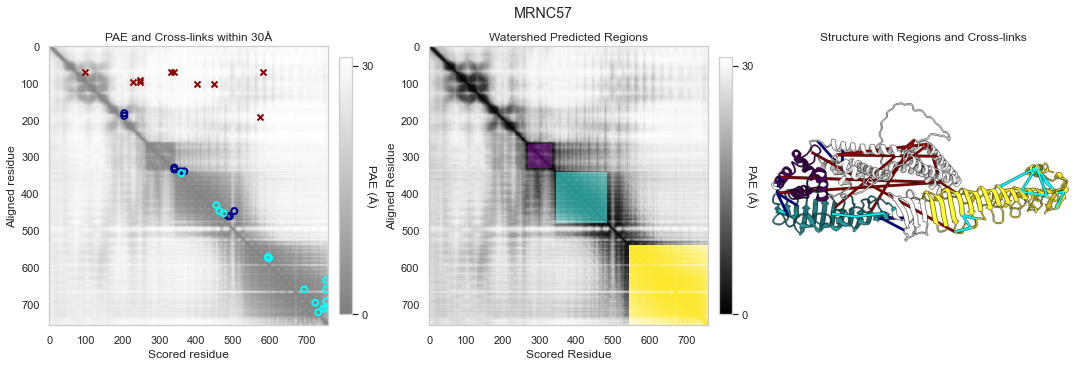

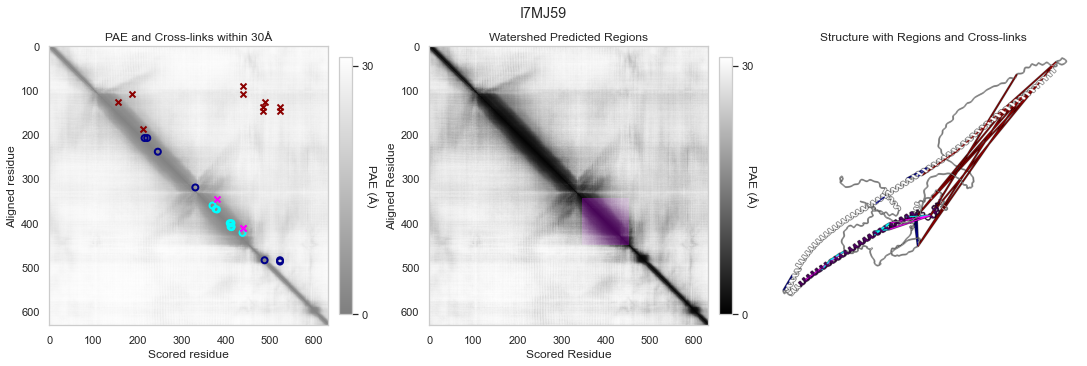

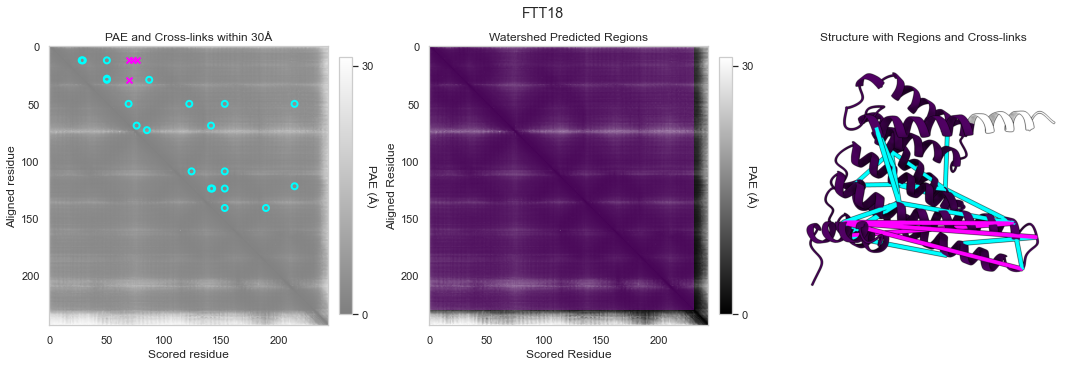

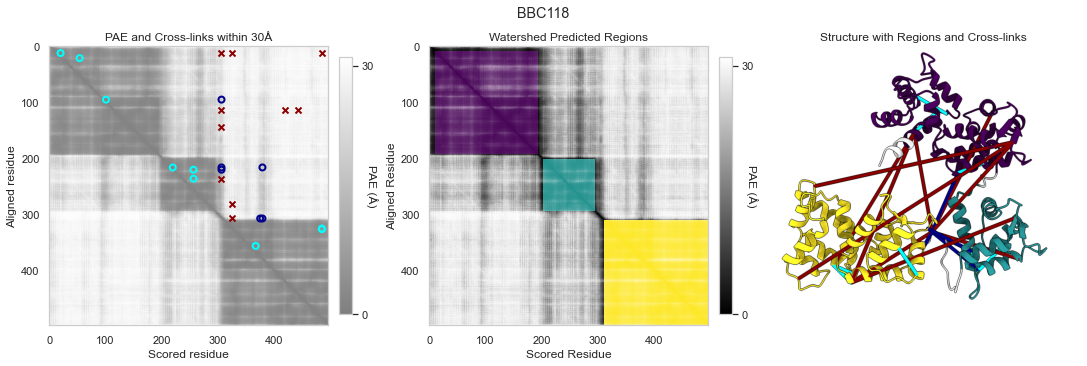

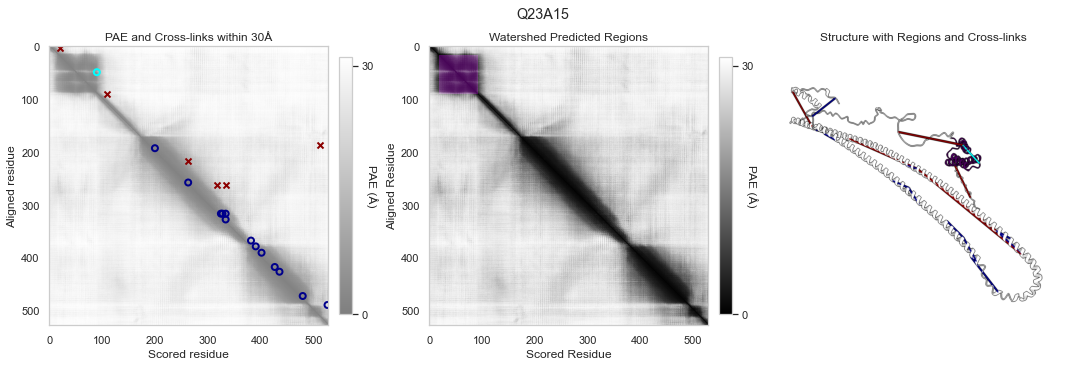

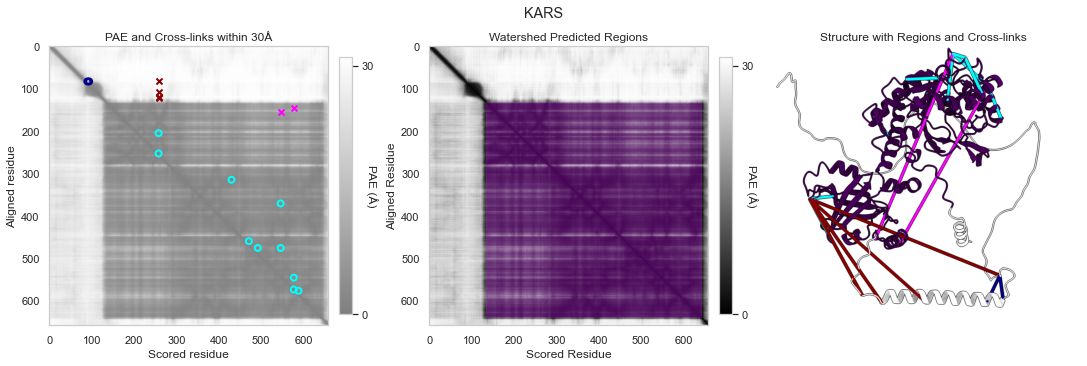

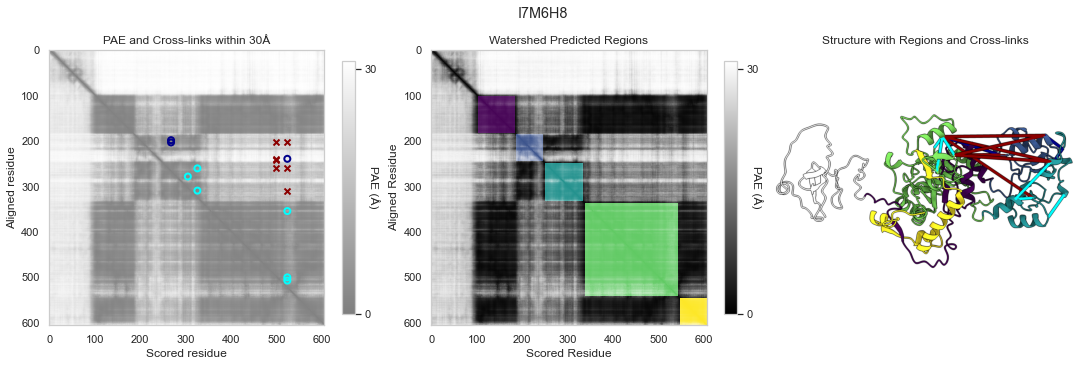

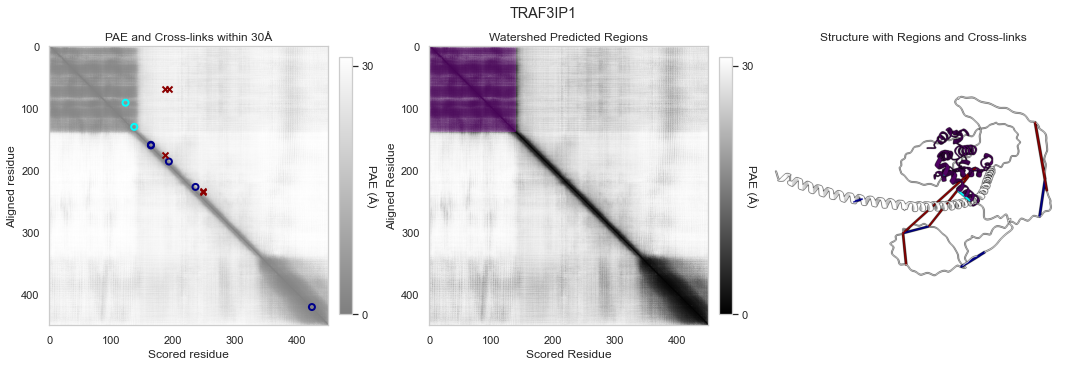

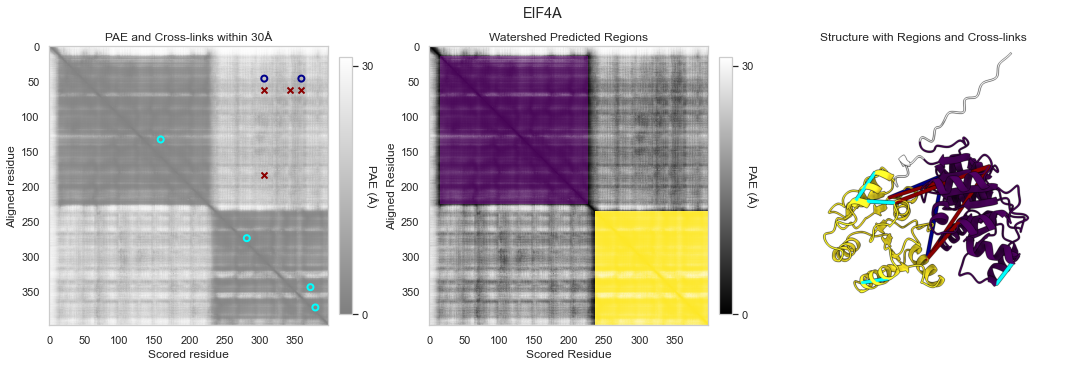

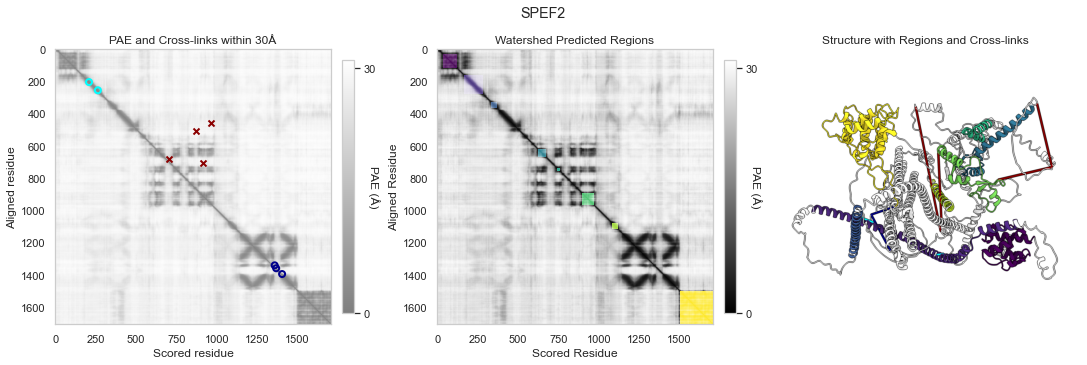

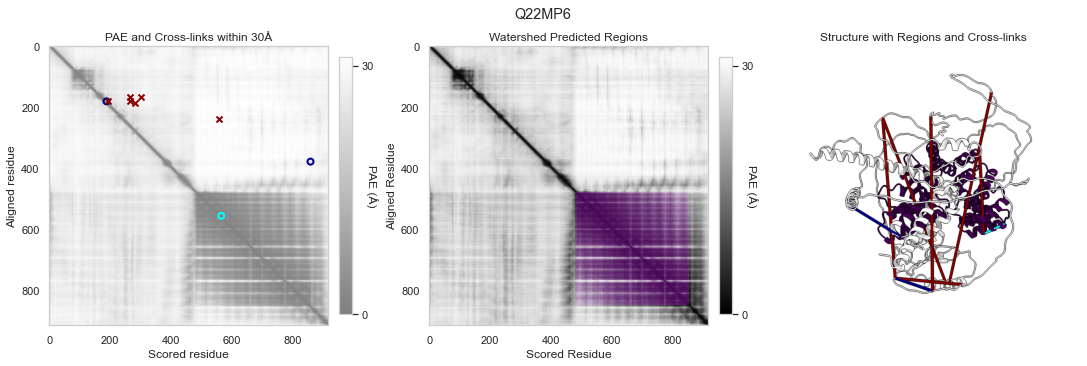

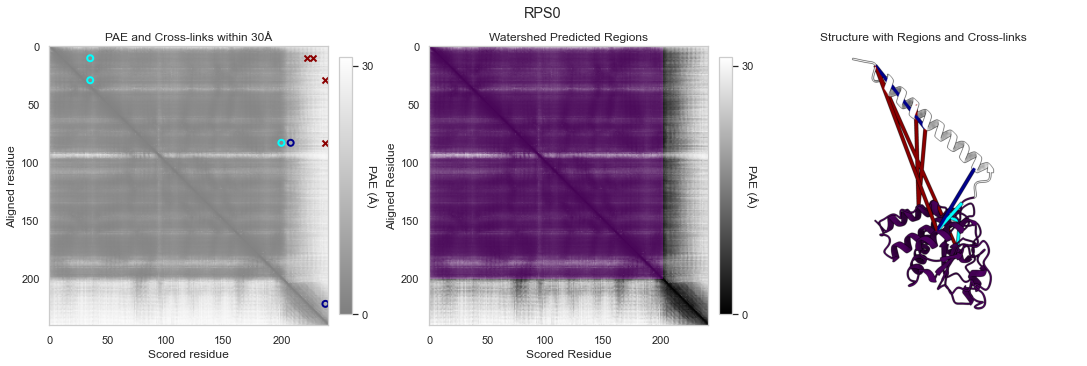

In [72]:
for protein in example_proteins:
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), constrained_layout=True, gridspec_kw={'width_ratios': [2, 2, 2.25]})
    fig.patch.set_facecolor('white')
    fig.suptitle(protein)
    ax = axes.ravel()

    plot_pae_xls(protein, ax[0], fig)
    plot_watershed_regions(paes[protein], labels[protein], ax[1], fig)

    # Include image of AlphaFold structure colored by watershed region with color-coded cross-links
    ax[2].imshow(mpimg.imread('chx/PTM/Images/{}.png'.format(sanitize_protein(protein))))
    ax[2].set_title("Structure with Regions and Cross-links")
    ax[2].axis('off')

    plt.savefig("figures/{}.svg".format(sanitize_protein(protein)), dpi = 300)
    plt.savefig("figures/{}.png".format(sanitize_protein(protein)), dpi = 300)